## Условие задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

In [1]:
# libraries import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import lightgbm
from tensorflow import keras

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
sns.set_style('whitegrid')

Загрузим все датасеты

## 1. EDA

In [2]:
# данные об электродах
arc = pd.read_csv('data_arc.csv')

In [3]:
# данные о подаче сыпучих материалов (объём)
bulk_vol = pd.read_csv('data_bulk.csv')

In [4]:
# данные о подаче сыпучих материалов (время)
bulk_time = pd.read_csv('data_bulk_time.csv')

In [5]:
# данные о продувке сплава газом
gas = pd.read_csv('data_gas.csv')

In [6]:
# результаты измерения температуры
temp = pd.read_csv('data_temp.csv')

In [7]:
# данные о проволочных материалах (объём)
wire = pd.read_csv('data_wire.csv')

In [8]:
# данные о проволочных материалах (время)
wire_time = pd.read_csv('data_wire_time.csv')

Посмотрим на каждый датасет в отдельности: типы данных, пропуски, дубликаты, распределение данных.

In [9]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [10]:
arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


Будем считать что у нас команда только русскоязычная и названия признаков менять и приводить к одному регистру не требуется.

In [11]:
arc.duplicated().sum()

0

В данных об электродах нет пропусков, нет дубликатов. Признаки начала нагрева и конца нагрева - признаки дат с указанием времени, нужно произвести приобразование типов данных.

In [12]:
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'])
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'])

In [13]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Теперь посмотрим на распределения/изменения данных. В данных об электродах нас интересуют признаки Активной и Реактивной мощности - то есть то, что напрямую влияет на потребление электроэнергии. Также хочется посмотреть на новый признак - длительность нагрева равный разнице конца и начала нагрева.

In [14]:
arc['Время нагрева'] = arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']

In [15]:
arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,00:02:28
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,00:02:17
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,00:05:38
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,00:02:06
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,00:03:30
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494,00:04:40


Так как Реактивная мощность и Активная для одного потребителя составляют полную мощность можно также сделать одни признак. Но пока лишь заметим, что отношение Активной мощности к Реактивной всегда одинаково для одного и того же оборудования - проверим это в наших данных на примере распределения.

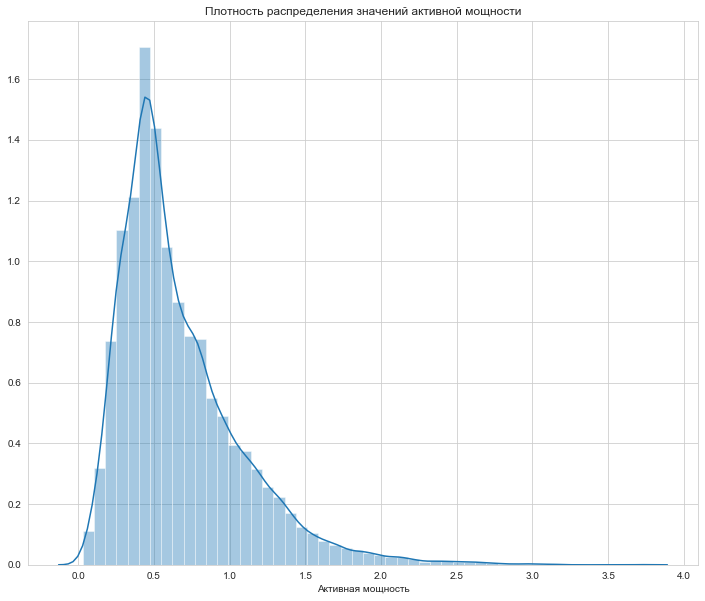

In [16]:
plt.figure(figsize=(12, 10))
sns.distplot(arc['Активная мощность'])
plt.title('Плотность распределения значений активной мощности');

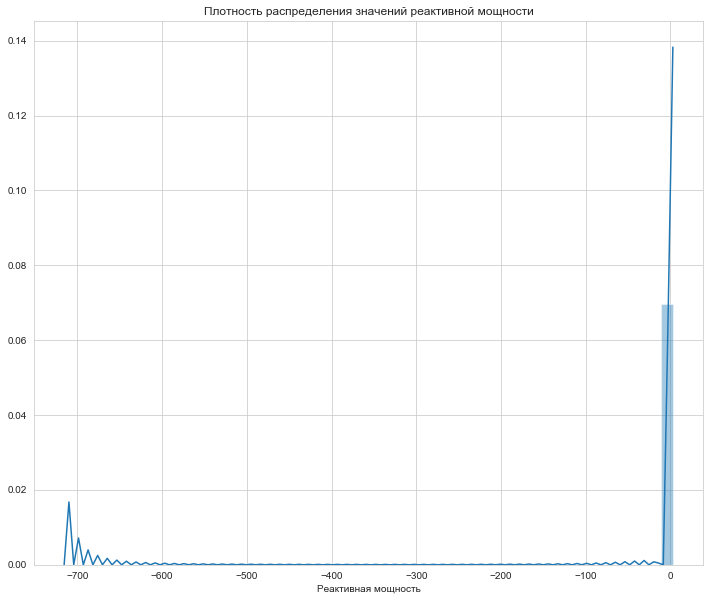

In [17]:
plt.figure(figsize=(12, 10))
sns.distplot(arc['Реактивная мощность']);
plt.title('Плотность распределения значений реактивной мощности');

Что-то не так со значениями реактивной мощности, взглянем поближе.

In [18]:
arc['Реактивная мощность'].describe()

count    14876.000000
mean         0.452592
std          5.878702
min       -715.504924
25%          0.290991
50%          0.415962
75%          0.637371
max          2.676388
Name: Реактивная мощность, dtype: float64

In [19]:
arc[arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924,00:01:49


У нас всего одно не верное значение. Как сказал выше, отношение активной к реактивной мощности для одного оборудования всегда одинаковое (может немного колебаться, но все же). Заполним выброс, вместо удаления, исходя из отношения мощностей. 

In [20]:
# Отношение колинеарный признак, откажемся от его использования и проверим изменение значения итоговой метрики
# arc['Отношение'] = arc['Активная мощность'] / arc['Реактивная мощность']

In [21]:
new_arc = arc[arc['Реактивная мощность'] > 0]

In [22]:
#new_arc['Отношение'].describe()

**Не уверен в корректности данных, т.к. отношение мощностей это косинус фи и он фиксирован для любого потребителя электроэнергии и может варьироваться в совсем небольшом диапазоне в зависимости от внешних факторов самой сети. Здесь же мы видим огросный разброс, чего быть не может на одном и том же оборудовании.**

Удалим экземпляр с признаком реактивной мощности меньше нуля - будем использовать данные new_arc.

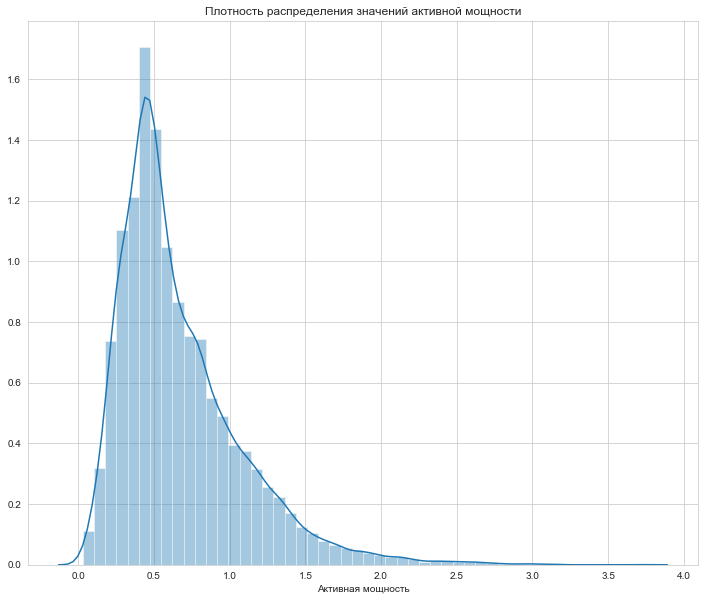

In [23]:
plt.figure(figsize=(12, 10))
sns.distplot(new_arc['Активная мощность'])
plt.title('Плотность распределения значений активной мощности');

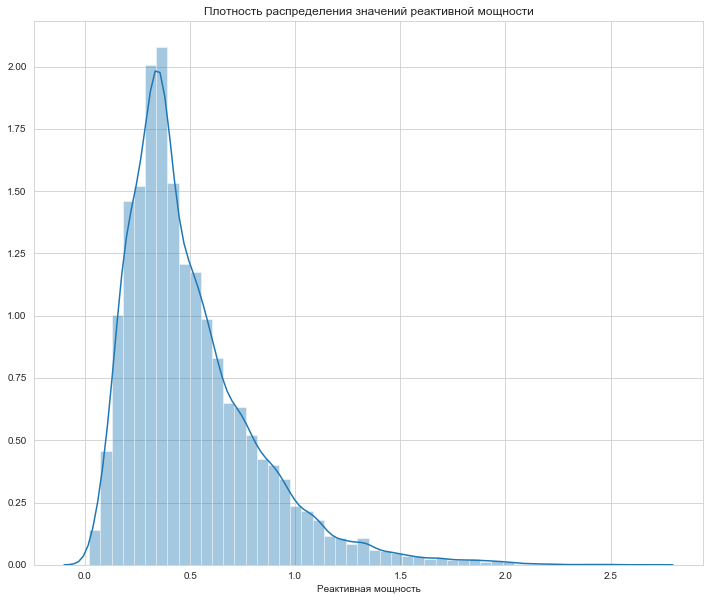

In [24]:
plt.figure(figsize=(12, 10))
sns.distplot(new_arc['Реактивная мощность']);
plt.title('Плотность распределения значений реактивной мощности');

Распределения схожи, выброса больше нет, распределения похожи на нормальные с правым хвостом. Теперь посмотрим на график времени нагрева во времени. И проверим как изменяется время нагрева.

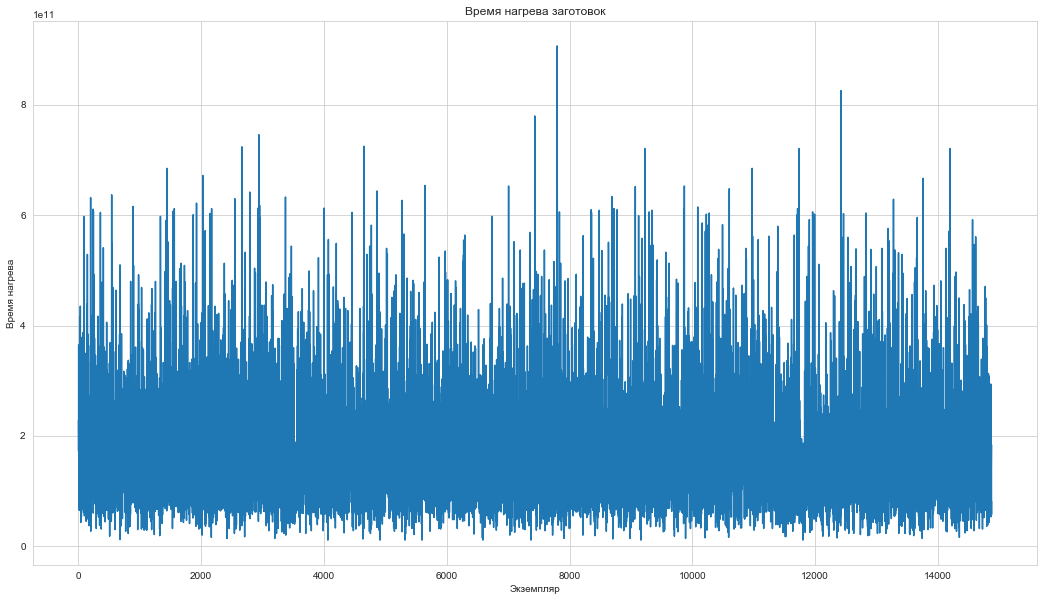

In [25]:
plt.figure(figsize=(18, 10))
plt.plot(new_arc['Время нагрева'])
plt.title('Время нагрева заготовок')
plt.xlabel('Экземпляр')
plt.ylabel('Время нагрева');

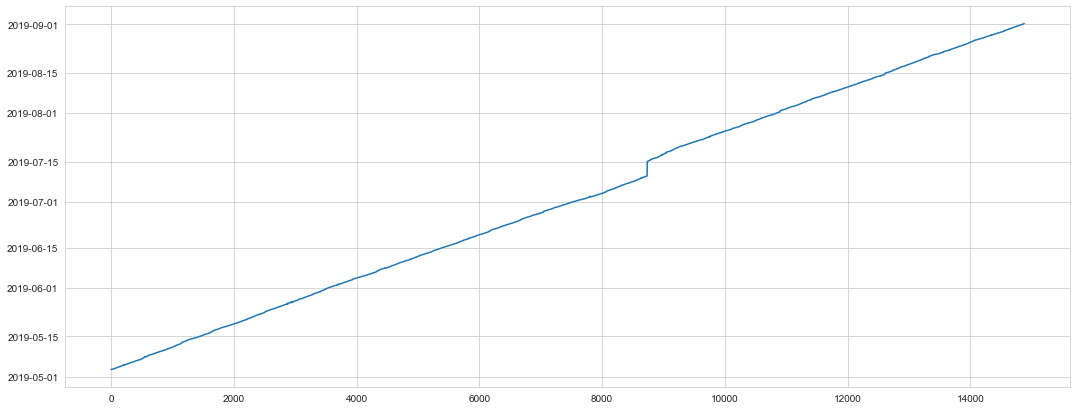

In [26]:
plt.figure(figsize=(18, 7))
plt.plot(new_arc['Начало нагрева дугой']);

Графики времени нагрева и изменения времени выглядят обычно, никаких бросающихся в глаза моментов нет (ну может только перерыв во времени начала). Есть выбросы по времени плавки. 

**Приступим к исследованию данных об объеме сыпучих материалов**

In [27]:
bulk_vol.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


Вопрос, что за материалы, или не важно??? Пропуски думаю можно заменить на нулевые значения, т.к. можно сделать предположение, что отсутствующие значения это не добавление ничего, т.е. 0

In [28]:
bulk_vol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [29]:
bulk_vol.duplicated().sum()

0

(Пока не будем) Попробуем заполнить пропуски нулями и посмотрим на изменения значений.

In [30]:
# bulk_vol.fillna(0, inplace=True)

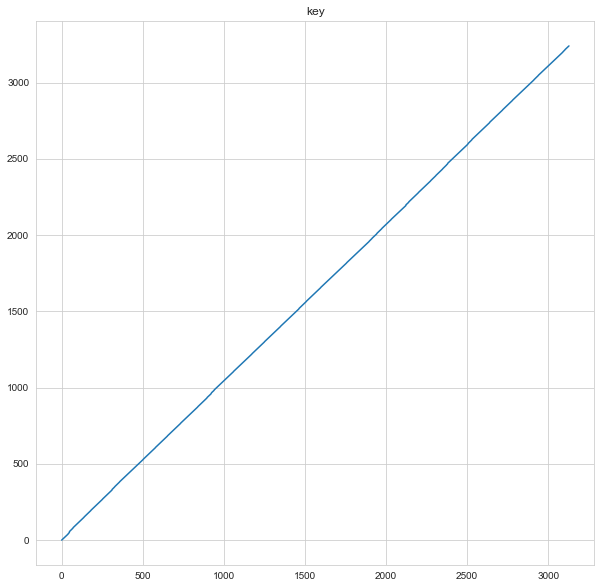

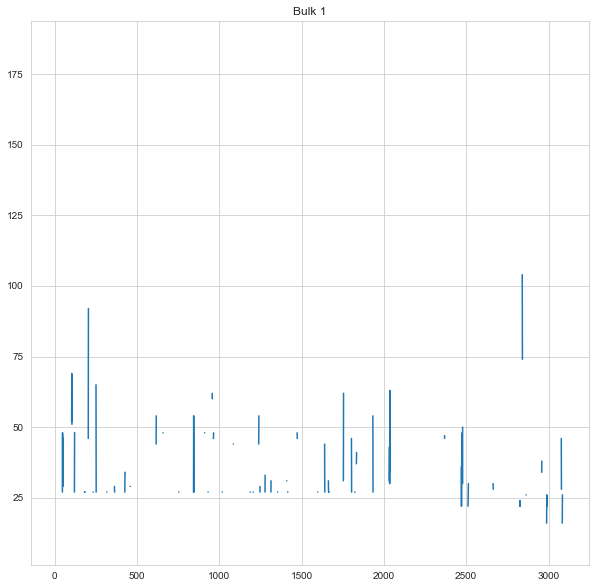

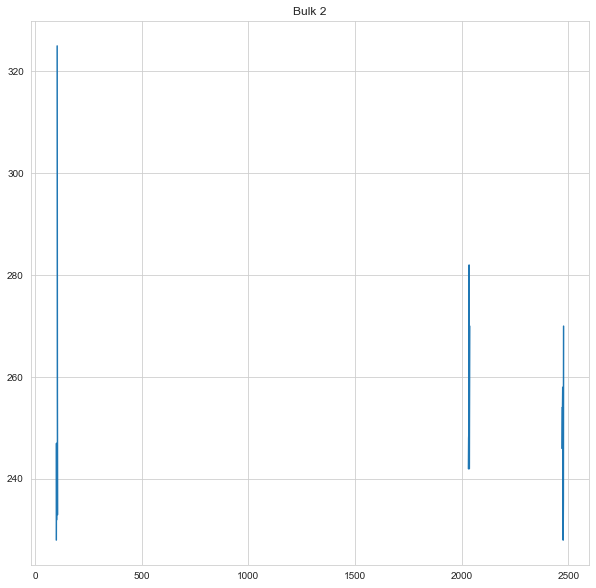

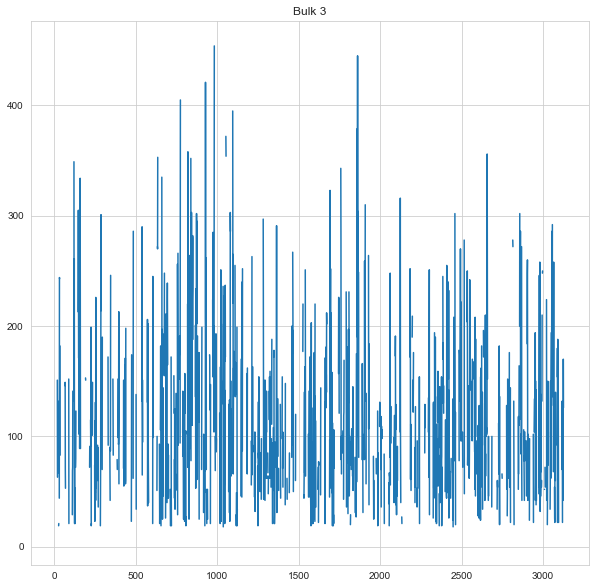

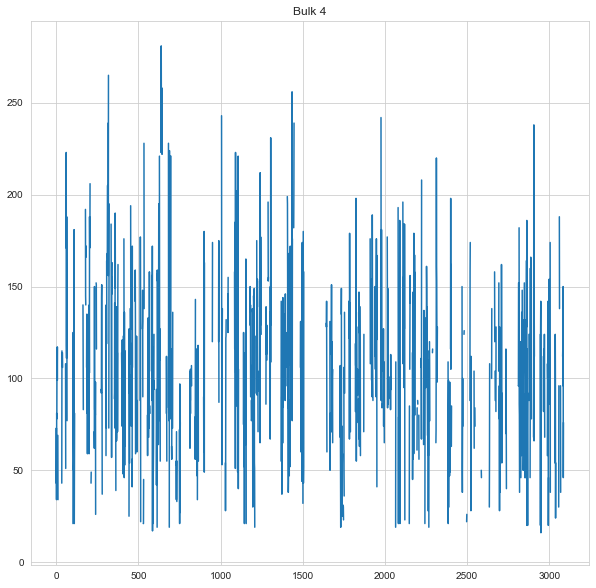

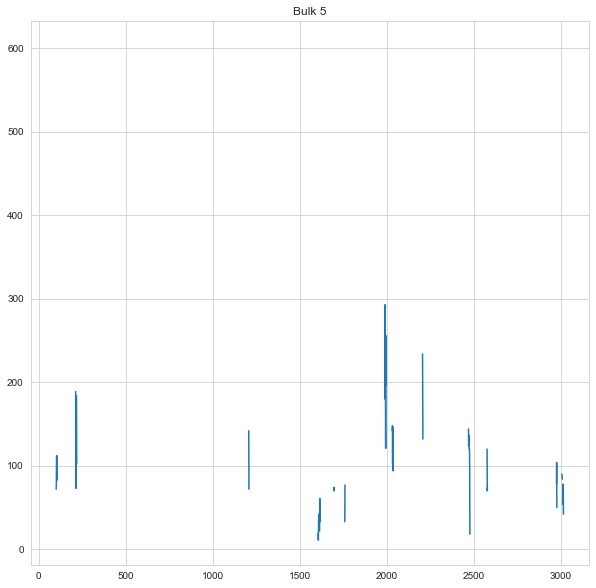

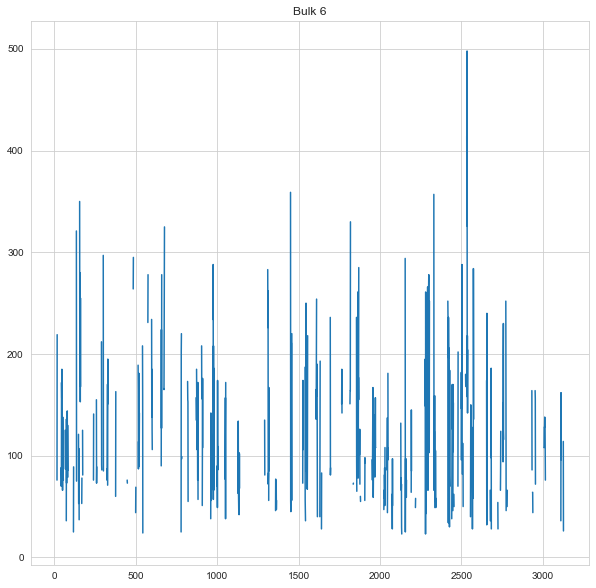

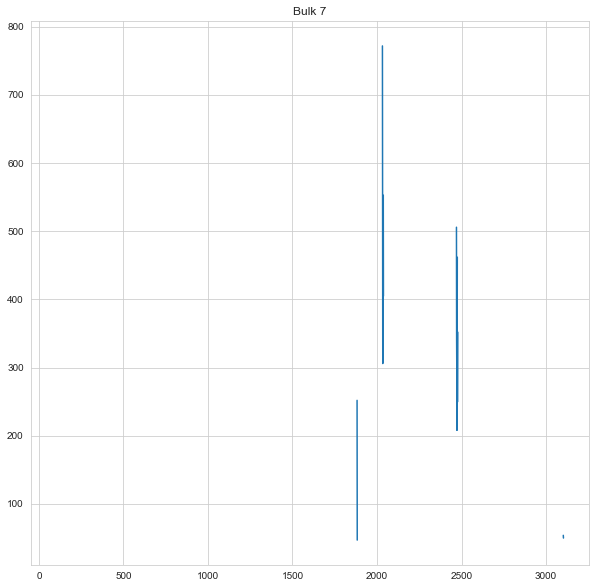

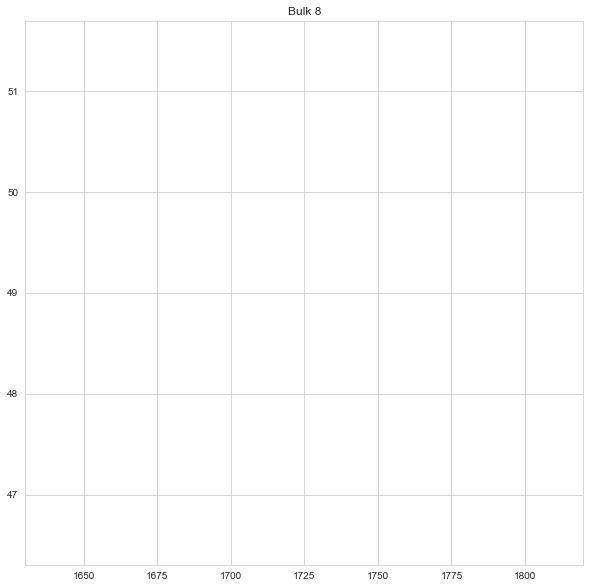

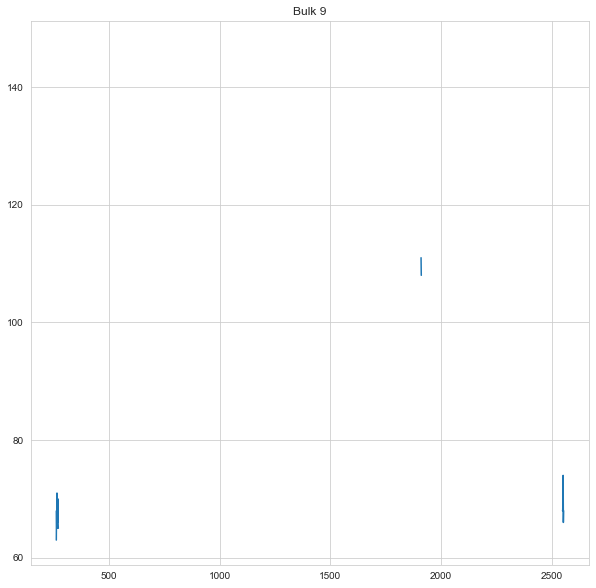

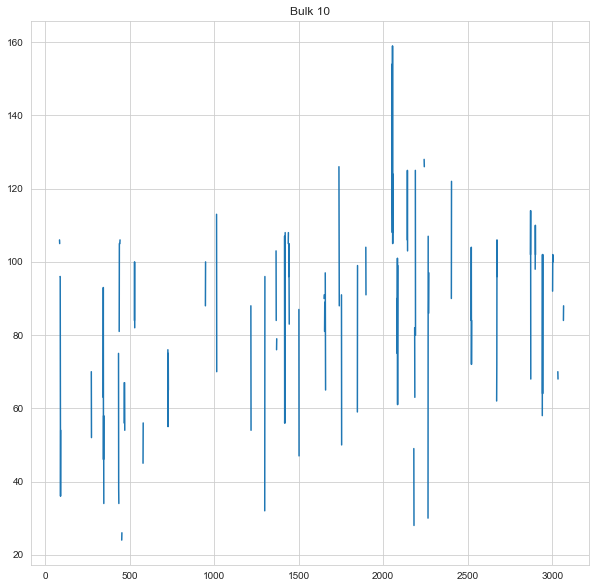

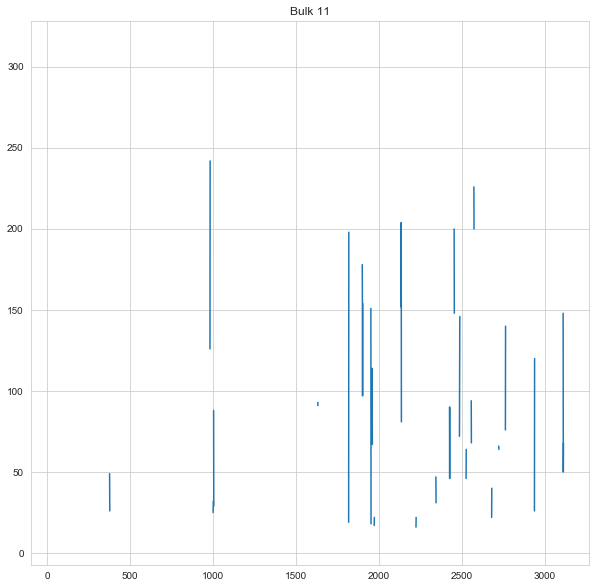

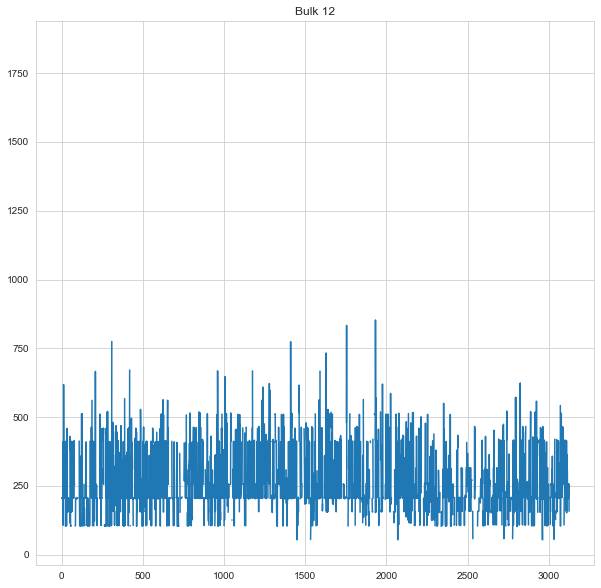

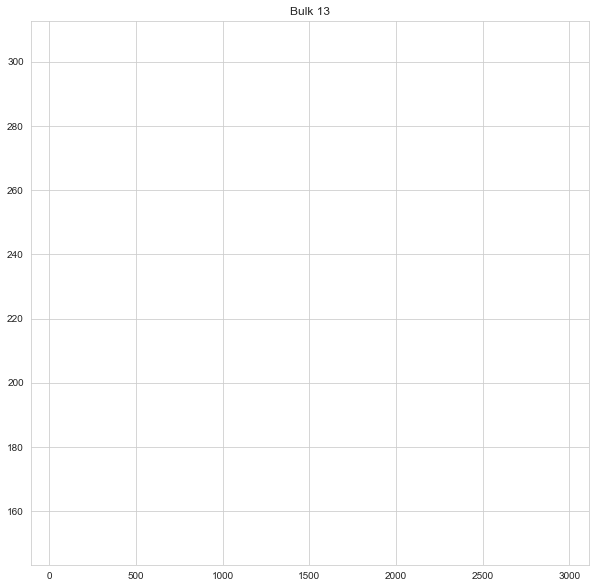

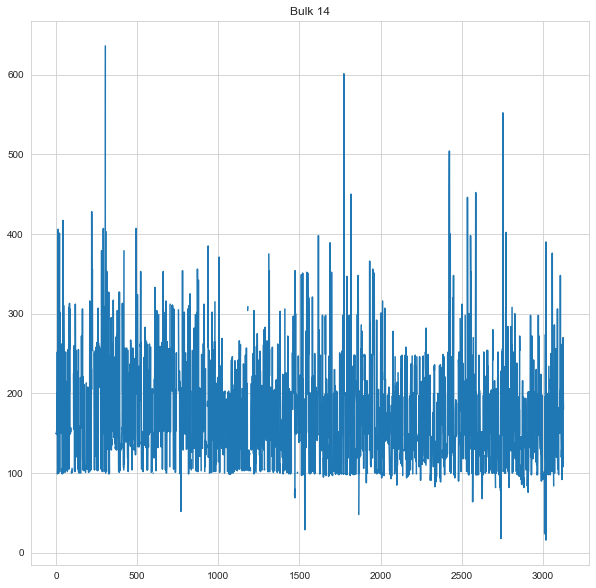

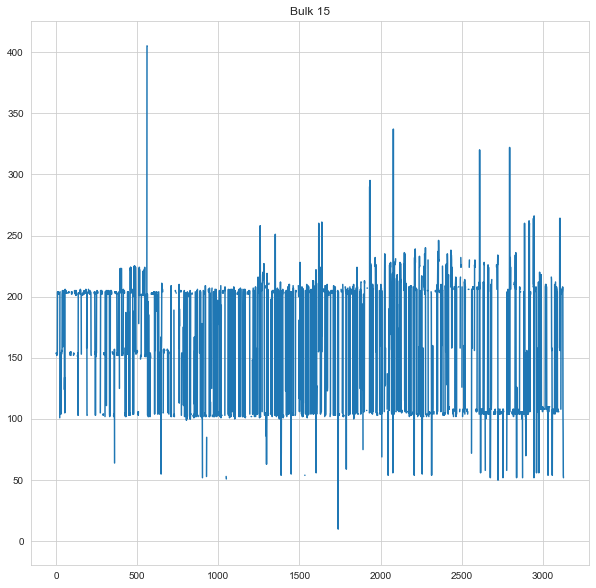

In [31]:
for col in bulk_vol.columns:
    plt.figure(figsize=(10, 10))
    plt.plot(bulk_vol[col])
    plt.title(col)
    plt.show();

In [32]:
for col in bulk_vol.columns:
    print(col)
    print('--------------------')
    print(bulk_vol[col].describe())
    print('--------------------')
    print()

key
--------------------
count    3129.000000
mean     1624.383509
std       933.337642
min         1.000000
25%       816.000000
50%      1622.000000
75%      2431.000000
max      3241.000000
Name: key, dtype: float64
--------------------

Bulk 1
--------------------
count    252.000000
mean      39.242063
std       18.277654
min       10.000000
25%       27.000000
50%       31.000000
75%       46.000000
max      185.000000
Name: Bulk 1, dtype: float64
--------------------

Bulk 2
--------------------
count     22.000000
mean     253.045455
std       21.180578
min      228.000000
25%      242.000000
50%      251.500000
75%      257.750000
max      325.000000
Name: Bulk 2, dtype: float64
--------------------

Bulk 3
--------------------
count    1298.000000
mean      113.879045
std        75.483494
min         6.000000
25%        58.000000
50%        97.500000
75%       152.000000
max       454.000000
Name: Bulk 3, dtype: float64
--------------------

Bulk 4
--------------------
count 

По объему добавок вопросов нет, возможно это от неполного понимания какое количество их должно быть.

**Перейдем к времени добавок сыпучих материалов**

In [33]:
bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [34]:
bulk_time.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


Посмотрим на количетсво материалов, время нагрева и добавления материалов. Попробуем найти видимую взаимосвязь.

In [35]:
new_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,00:02:28
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,00:02:17
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,00:05:38
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,00:02:06
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,00:03:30
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494,00:04:40


Есть предположение, что количество раз добавление сыпучего материала и его количество определяют время нагрева, но пока непонятно почему при схожих материалах для первой и второй партии время разниться и количество нагревов. Попробуем в дальнейшем вернуться к этому вопросу.

**Исследуем данные о продувке сплавов газом**

In [36]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [37]:
gas.head(10)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [38]:
gas.duplicated().sum()

0

Пропусков нет, дубликатов нет. Посмотрим на распределение.

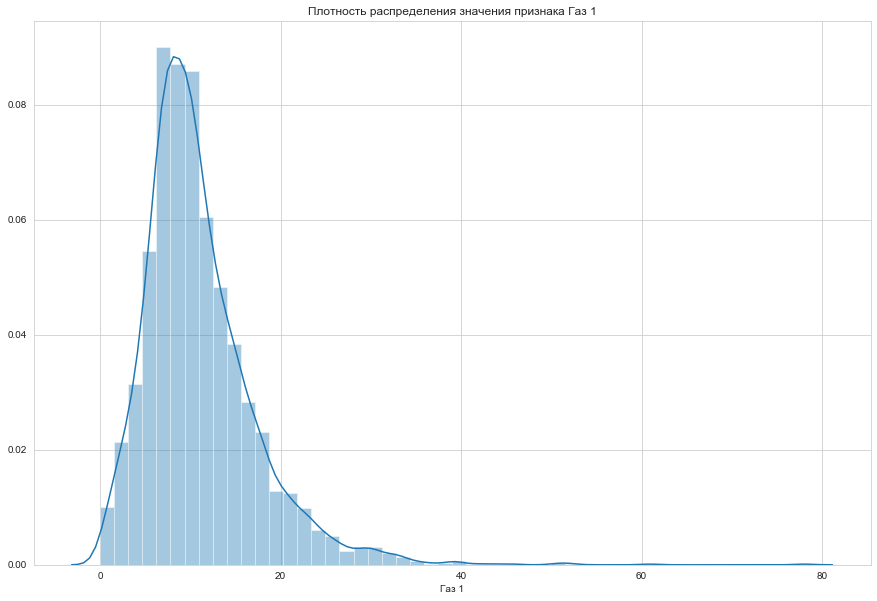

In [39]:
plt.figure(figsize=(15, 10))
sns.distplot(gas['Газ 1']);
plt.title('Плотность распределения значения признака Газ 1');

Распределение похоже на нормальные с правым хвостом. Есть выбросы, возможно связанные с какими-то факторами коррелирующими с временем нагрева и соответственно с затратами на электроэнергию.

**Исследуем данные об измерениях температуры**

In [40]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [41]:
temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [42]:
temp.duplicated().sum()

0

Дубликатов нет, есть пропуски в признаке Температуры. Признак времени нужно привести к нужному типу. Посмотрим на значения признаков.

In [43]:
temp['Время замера'] = pd.to_datetime(temp['Время замера'])

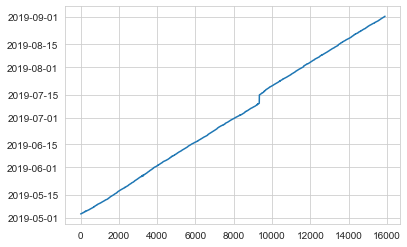

In [44]:
plt.plot(temp['Время замера']);

Замеры температуры по времени совпадают со временем нагрева, можно соединить датасеты.

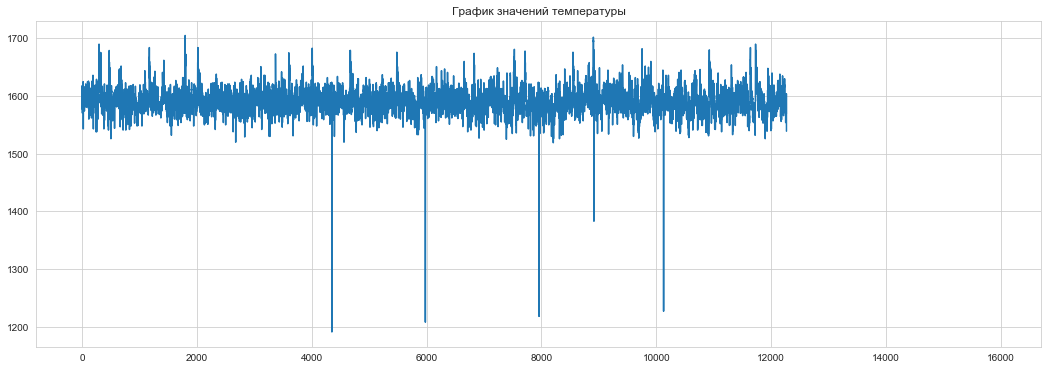

In [45]:
plt.figure(figsize=(18, 6))
plt.plot(temp['Температура'])
plt.title('График значений температуры');

Нужно хорошо подумать как заполнять пропуски в значениях признака Температура - возможно просто среднее, а может попробовать как-то учесть колебания значений температуры, а может предсказать какой-нибудь предиктивной моделью...

In [46]:
temp.tail(25)

,key,Время замера,Температура
15882,3237,2019-08-31 23:05:43,NaN
15883,3238,2019-08-31 23:30:31,1584.0
15884,3238,2019-08-31 23:37:26,NaN
15885,3238,2019-08-31 23:43:00,NaN
15886,3239,2019-09-01 01:31:47,1598.0
15887,3239,2019-09-01 01:42:46,NaN
15888,3239,2019-09-01 01:48:00,NaN
15889,3239,2019-09-01 01:59:27,NaN
15890,3239,2019-09-01 02:13:30,NaN
15891,3239,2019-09-01 02:22:15,NaN


**Я УДАЛИЛ ЛИШНИЕ ТЕМПЕРАТУРЫ В ПРОЦЕССЕ СОЗДАНИЯ ПИВОТА - ИСПОЛЬЗОВАЛ ЛИШЬ НАЧАЛЬНУЮ И КОНЕЧНУЮ ТЕМПЕРАТУРЫ**

In [47]:
temp.fillna(0, inplace=True)

In [48]:
temp.isnull().sum()

key             0
Время замера    0
Температура     0
dtype: int64

**Исследуем данные о проволочных материалах - объемы.**

In [49]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [50]:
wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
wire.duplicated().sum()

0

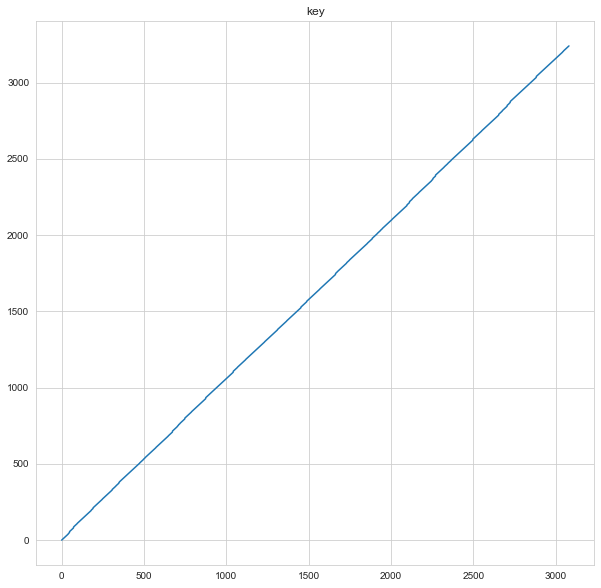

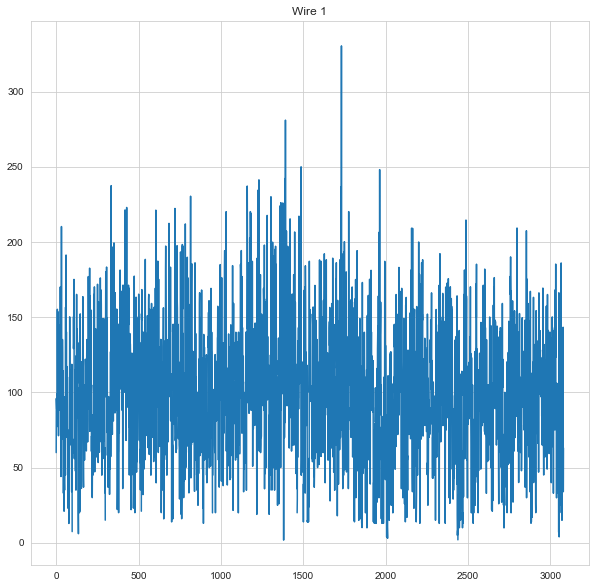

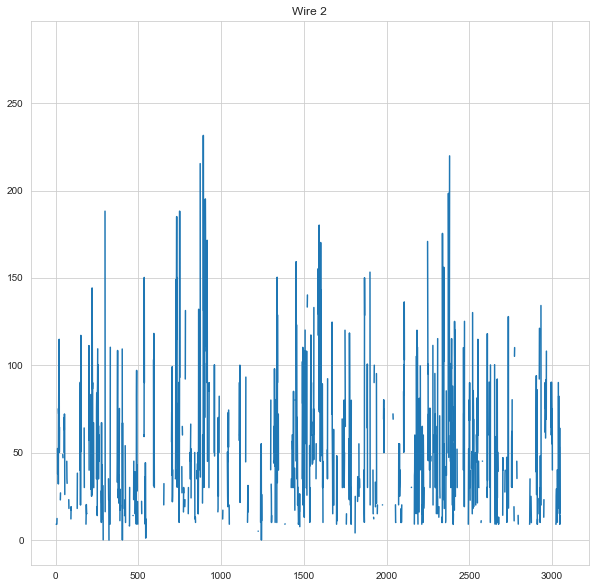

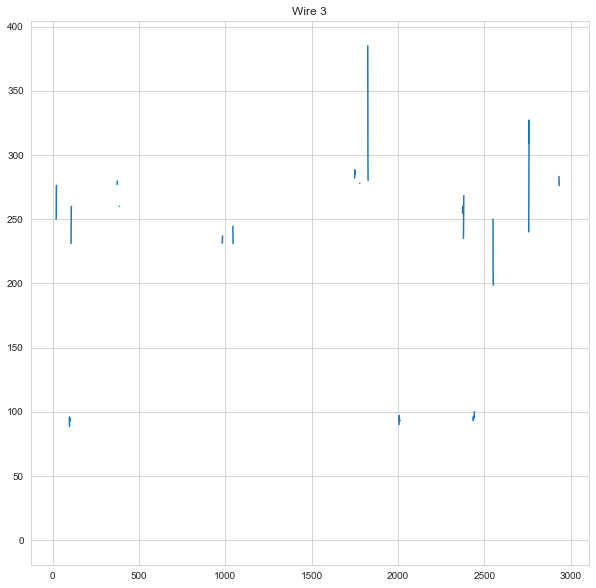

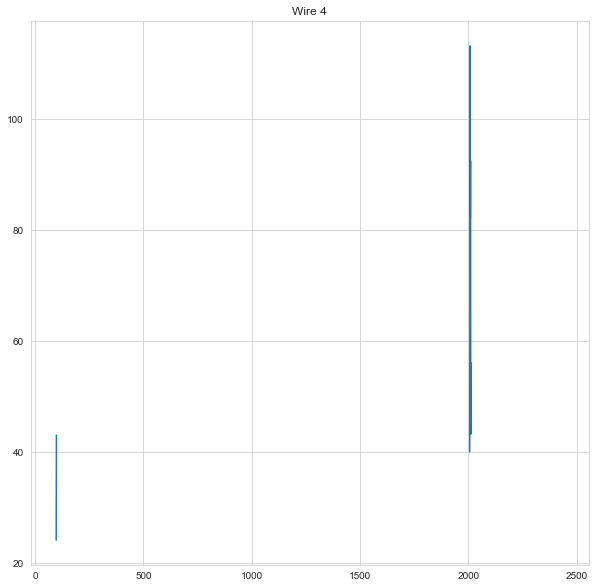

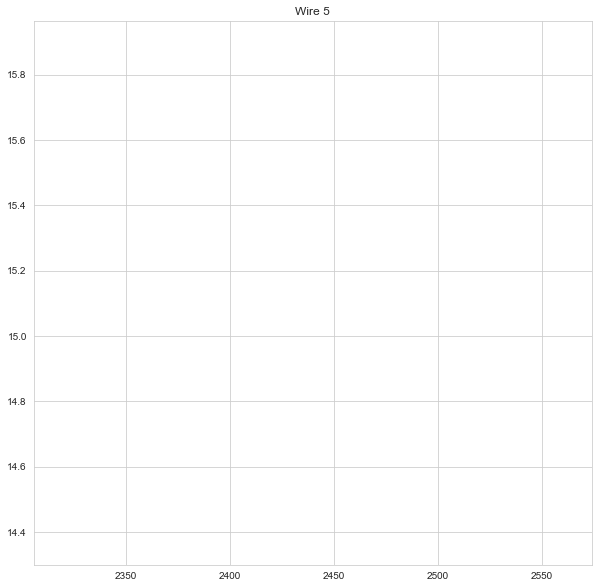

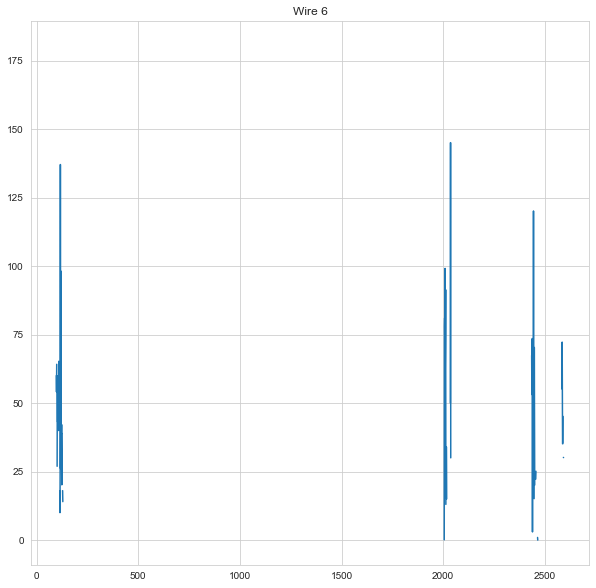

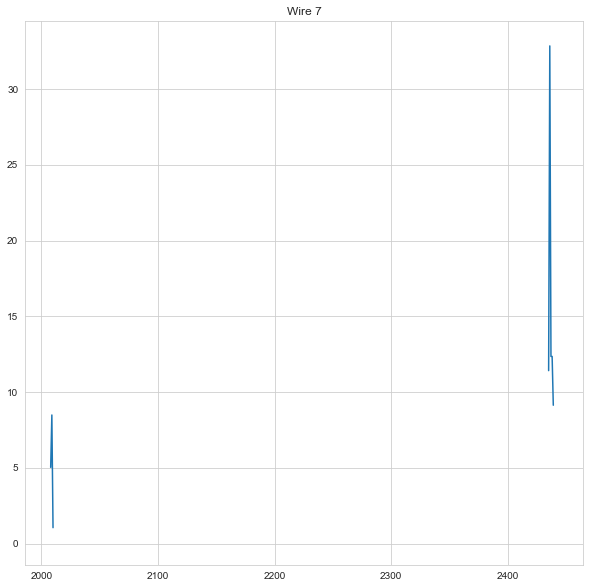

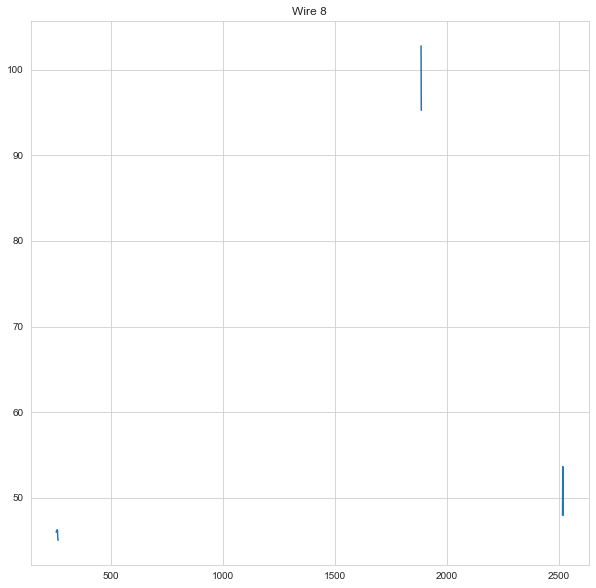

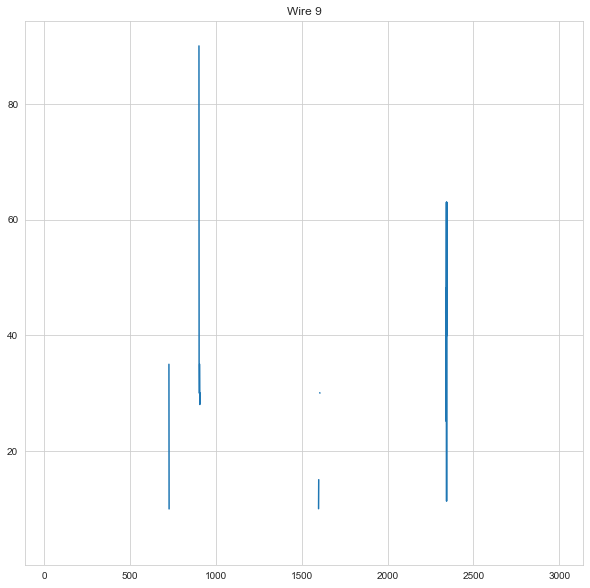

In [52]:
for col in wire.columns:
    plt.figure(figsize=(10, 10))
    plt.plot(wire[col])
    plt.title(col)
    plt.show();

Дубликатов нет, есть пропуски (как и в сыпучих материалах). Есть несколько основных материалов, которые используются чаще других. 

**Посмотрим на время добавления проволочных материалов**

In [53]:
wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [54]:
wire_time.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
wire_time.duplicated().sum()

0

Аналогично данным о сыпучих материалах соединил бы данные об объемах и времени добавления проволочных материалов.

## Дальнейший план:

1. Соединил бы датасеты о материалах в один.
2. Соединил бы данные об электродах и температурах.
3. Подумать как соединить все получившиеся датасеты в один и соединить с данными о газе.
4. Или до первых трех пунктов или после, заполнить пропуски - стратегия заполнения зависит от данных. Самая хитрая думаю должна быть для температуры замеров.
5. Подумать над созданием новых признаков.
6. Определить главный критерий потребления электроэнергии - пока видиться время нагрева общее.
7. Подумать как можно оптимизировать (снизить) время нагрева и как в этом может помочь машинное обучение.

## 2. Data preparation and feature engineering

**Внимательно посмотрим на данные об электродах и на данные о температурах, потом решим как их соединить.**

In [56]:
new_arc.head(25)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,00:02:28
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,00:02:17
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,00:05:38
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,00:02:06
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,00:03:30
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494,00:04:40


In [57]:
temp.head(25)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


**Так как экземпляров для данных по электродам и по температурам для одних и тех же партий различное количество, то будем пробовать доставать из данных о температурах первые и последние значения (первые для предсказания, последняя таргет). В данных об электродах попробуем сгенерировать как можно больше новых признаков (далее их проверим на важность и лишние отбросим).**

In [58]:
# сначала займемся температурами
temp_table = temp.pivot_table(index='key', values=['Время замера', 'Температура'], aggfunc=['first', 'last'])

In [59]:
temp_table.head(10)

first                            last            
           Время замера Температура        Время замера Температура
key                                                                
1   2019-05-03 11:16:18      1571.0 2019-05-03 11:30:39      1613.0
2   2019-05-03 11:37:27      1581.0 2019-05-03 11:59:12      1602.0
3   2019-05-03 12:13:17      1596.0 2019-05-03 12:34:57      1599.0
4   2019-05-03 12:52:57      1601.0 2019-05-03 12:59:25      1625.0
5   2019-05-03 13:23:19      1576.0 2019-05-03 13:36:01      1602.0
6   2019-05-03 13:49:24      1543.0 2019-05-03 14:12:29      1596.0
7   2019-05-03 14:19:43      1586.0 2019-05-03 14:42:37      1599.0
8   2019-05-03 15:07:18      1577.0 2019-05-03 15:22:52      1598.0
9   2019-05-03 15:37:03      1587.0 2019-05-03 16:01:16      1592.0
10  2019-05-03 16:14:29      1574.0 2019-05-03 16:36:08      1593.0

Создадим нормальный датафрейм из пивота

In [60]:
temp_join = pd.DataFrame()

In [61]:
temp_join['Начальный замер'] = temp_table['first']['Время замера']
temp_join['Начальная температура'] = temp_table['first']['Температура']
temp_join['Конечный замер'] = temp_table['last']['Время замера']
temp_join['Конечная температура'] = temp_table['last']['Температура']

In [62]:
temp_join = temp_join.reset_index()

In [63]:
temp_join.head(10)

,key,Начальный замер,Начальная температура,Конечный замер,Конечная температура
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0
5,6,2019-05-03 13:49:24,1543.0,2019-05-03 14:12:29,1596.0
6,7,2019-05-03 14:19:43,1586.0,2019-05-03 14:42:37,1599.0
7,8,2019-05-03 15:07:18,1577.0,2019-05-03 15:22:52,1598.0
8,9,2019-05-03 15:37:03,1587.0,2019-05-03 16:01:16,1592.0
9,10,2019-05-03 16:14:29,1574.0,2019-05-03 16:36:08,1593.0


In [64]:
temp_join.shape

(3216, 5)

In [65]:
temp_join = temp_join[temp_join['Конечная температура'] != 0]

In [66]:
temp_join.shape

(2477, 5)

In [67]:
""" теперь займемся электродами - сначала добавим новый признак - полную мощность 
(корень квадрата активной и реактивной мощностей) """

def full_power(data):
    return (data['Активная мощность']**2 + data['Реактивная мощность']**2)**0.5

In [68]:
try:
    new_arc['Полная мощность'] = new_arc.apply(full_power, axis=1)
except:
    print('Check the function')

In [69]:
new_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,00:03:48,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,00:03:05,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,00:02:52,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,00:06:05,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,00:02:28,0.807239
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,00:02:17,0.521549
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,00:05:38,1.574162
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,00:02:06,0.577638
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,00:03:30,0.975867
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494,00:04:40,1.256527


In [70]:
# теперь добавим время нагрева в секундах
new_arc['Время нагрева сек'] = new_arc['Время нагрева'].dt.seconds

In [71]:
# теперь создадим таблицу с нужными параметрами

arc_table = new_arc.pivot_table(index='key', 
                                values=['Начало нагрева дугой', 'Конец нагрева дугой', 'Активная мощность', \
                                        'Реактивная мощность', 'Время нагрева сек', 'Полная мощность'],
                               aggfunc=['first', 'last', 'mean', 'count', 'sum', 'min', 'max'])

In [72]:
arc_table.head()

first                                        \
    Активная мощность Время нагрева сек Конец нагрева дугой   
key                                                           
1            0.976059               228 2019-05-03 11:06:02   
2            0.438063               137 2019-05-03 11:36:31   
3            1.062053               280 2019-05-03 12:11:34   
4            0.875313               207 2019-05-03 12:43:04   
5            0.950026               251 2019-05-03 13:15:24   

                                                              \
    Начало нагрева дугой Полная мощность Реактивная мощность   
key                                                            
1    2019-05-03 11:02:14        1.193639            0.687084   
2    2019-05-03 11:34:14        0.521549            0.283043   
3    2019-05-03 12:06:54        1.256527            0.671494   
4    2019-05-03 12:39:37        1.069423            0.614404   
5    2019-05-03 13:11:13        1.174466            0.690523   

                 last                                        \
    Активная мощность Время нагрева сек Конец нагрева дугой   
key                                                           
1            0.692755               148 2019-05-03 11:28:37   
2            0.827743               210 2019-05-03 11:53:18   
3            0.250280                65 2019-05-03 12:32:19   
4            1.220955               278 2019-05-03 12:57:50   
5            0.267457                71 2019-05-03 13:33:55   

                                                              \
    Начало нагрева дугой Полная мощность Реактивная мощность   
key                                                            
1    2019-05-03 11:26:09        0.807239            0.414397   
2    2019-05-03 11:49:48        0.975867            0.516874   
3    2019-05-03 12:31:14        0.294865            0.155901   
4    2019-05-03 12:53:12        1.435385            0.754719   
5    2019-05-03 13:32:44        0.323503            0.181992   

                 mean                                                        \
    Активная мощность Время нагрева сек Полная мощность Реактивная мощность   
key                                                                           
1            0.975629            219.60        1.165279            0.636648   
2            0.763150            202.75        0.912304            0.499528   
3            0.505176            131.00        0.597907            0.319815   
4            0.802313            185.25        0.953741            0.515074   
5            0.836793            217.25        1.008939            0.563161   

                count                                        \
    Активная мощность Время нагрева сек Конец нагрева дугой   
key                                                           
1                   5                 5                   5   
2                   4                 4                   4   
3                   5                 5                   5   
4                   4                 4                   4   
5                   4                 4                   4   

                                                              \
    Начало нагрева дугой Полная мощность Реактивная мощность   
key                                                            
1                      5               5                   5   
2                      4               4                   4   
3                      5               5                   5   
4                      4               4                   4   
5                      4               4                   4   

                  sum                                                        \
    Активная мощность Время нагрева сек Полная мощность Реактивная мощность   
key                                                                           
1            4.878147              1098        5.826395            3.183241   
2            

Создадим нормальный датафрейм для электродов из пивота

In [73]:
arc_join = pd.DataFrame()

In [74]:
arc_join['Начало нагрева'] = arc_table['first']['Начало нагрева дугой']
#arc_join['Время первого нагрева'] = arc_table['first']['Время нагрева сек']
#arc_join['Активная мощ первого нагрева'] = arc_table['first']['Активная мощность']
#arc_join['Реактивная мощ первого нагрева'] = arc_table['first']['Реактивная мощность']
#arc_join['Полная мощ первого нагрева'] = arc_table['first']['Полная мощность']
#arc_join['Отношение мощ первого нагрева'] = arc_table['first']['Отношение']

arc_join['Конец нагрева'] = arc_table['last']['Конец нагрева дугой']
#arc_join['Время последнего нагрева'] = arc_table['last']['Время нагрева сек']
#arc_join['Активная мощ последнего нагрева'] = arc_table['last']['Активная мощность']
#arc_join['Реактивная мощ последнего нагрева'] = arc_table['last']['Реактивная мощность']
#arc_join['Полная мощ последнего нагрева'] = arc_table['last']['Полная мощность']
#arc_join['Отношение мощ последнего нагрева'] = arc_table['last']['Отношение']

#arc_join['Среднее время нагрева'] = arc_table['mean']['Время нагрева сек']
#arc_join['Средняя активная мощ нагрева'] = arc_table['mean']['Активная мощность']
#arc_join['Средняя реактивная мощ нагрева'] = arc_table['mean']['Реактивная мощность']
#arc_join['Средняя полная мощ нагрева'] = arc_table['mean']['Полная мощность']
#arc_join['Среднее отношение мощ нагрева'] = arc_table['mean']['Отношение']

arc_join['Суммарное время нагрева'] = arc_table['sum']['Время нагрева сек']
#arc_join['Суммарная активная мощ нагрева'] = arc_table['sum']['Активная мощность']
#arc_join['Суммарная реактивная мощ нагрева'] = arc_table['sum']['Реактивная мощность']
arc_join['Суммарная полная мощ нагрева'] = arc_table['sum']['Полная мощность']

#arc_join['Минимальное время нагрева'] = arc_table['min']['Время нагрева сек']
#arc_join['Минимальная активная мощ нагрева'] = arc_table['min']['Активная мощность']
#arc_join['Минимальная реактивная мощ нагрева'] = arc_table['min']['Реактивная мощность']
#arc_join['Минимальная полная мощ нагрева'] = arc_table['min']['Полная мощность']
#arc_join['Минимальное отношение мощ нагрева'] = arc_table['min']['Отношение']

#arc_join['Минимальное время нагрева'] = arc_table['max']['Время нагрева сек']
#arc_join['Минимальная активная мощ нагрева'] = arc_table['max']['Активная мощность']
#arc_join['Минимальная реактивная мощ нагрева'] = arc_table['max']['Реактивная мощность']
#arc_join['Минимальная полная мощ нагрева'] = arc_table['max']['Полная мощность']
#arc_join['Минимальное отношение мощ нагрева'] = arc_table['max']['Отношение']

arc_join['Количество нагревов'] = arc_table['count']['Активная мощность']

In [75]:
arc_join = arc_join.reset_index()

In [76]:
arc_join.head()

,key,Начало нагрева,Конец нагрева,Суммарное время нагрева,Суммарная полная мощ нагрева,Количество нагревов
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,1098,5.826395,5
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,811,3.649216,4
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,655,2.989534,5
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,741,3.814962,4
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,869,4.035758,4


In [77]:
# проверим общее время нагрева создав новый признак
arc_join['Общее время нагрева'] = (arc_join['Конец нагрева'] - arc_join['Начало нагрева']).dt.seconds

In [78]:
arc_join[['Общее время нагрева', 'Суммарное время нагрева']].head()

,Общее время нагрева,Суммарное время нагрева
0,1583,1098
1,1144,811
2,1525,655
3,1093,741
4,1362,869


Логично, т.к. периоды нагрева прерывают для добавления материалов. Соответственно можно создать признак времени охлаждения во время процесса. 

In [79]:
arc_join['Время охлаждения'] = arc_join['Общее время нагрева'] - arc_join['Суммарное время нагрева']

**Теперь соединим таблицы**

In [80]:
temp_join.shape

(2477, 5)

In [81]:
arc_join.shape

(3214, 8)

In [82]:
set(temp_join.key) - set(arc_join.key)

{195, 279}

В данных о температурах на два экземпляра больше чем в данных об электродах

In [83]:
arc_temp = temp_join.merge(arc_join, on='key')

In [84]:
arc_temp.head(5)

,key,Начальный замер,Начальная температура,Конечный замер,Конечная температура,Начало нагрева,Конец нагрева,Суммарное время нагрева,Суммарная полная мощ нагрева,Количество нагревов,Общее время нагрева,Время охлаждения
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,2019-05-03 11:02:14,2019-05-03 11:28:37,1098,5.826395,5,1583,485
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,2019-05-03 11:34:14,2019-05-03 11:53:18,811,3.649216,4,1144,333
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,2019-05-03 12:06:54,2019-05-03 12:32:19,655,2.989534,5,1525,870
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,2019-05-03 12:39:37,2019-05-03 12:57:50,741,3.814962,4,1093,352
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,2019-05-03 13:11:13,2019-05-03 13:33:55,869,4.035758,4,1362,493


In [85]:
arc_temp.tail(5)

,key,Начальный замер,Начальная температура,Конечный замер,Конечная температура,Начало нагрева,Конец нагрева,Суммарное время нагрева,Суммарная полная мощ нагрева,Количество нагревов,Общее время нагрева,Время охлаждения
2470,2495,2019-08-06 00:35:45,1570.0,2019-08-06 00:54:42,1591.0,2019-08-06 00:31:05,2019-08-06 00:51:13,723,3.986869,4,1208,485
2471,2496,2019-08-06 01:02:54,1554.0,2019-08-06 01:29:52,1591.0,2019-08-06 01:00:06,2019-08-06 01:23:32,940,5.057033,6,1406,466
2472,2497,2019-08-06 01:41:53,1571.0,2019-08-06 01:53:50,1589.0,2019-08-06 01:38:01,2019-08-06 01:50:45,569,2.885017,3,764,195
2473,2498,2019-08-06 02:03:49,1591.0,2019-08-06 02:25:31,1594.0,2019-08-06 01:57:46,2019-08-06 02:20:24,750,4.143749,5,1358,608
2474,2499,2019-08-06 02:40:25,1569.0,2019-08-06 03:00:28,1603.0,2019-08-06 02:32:56,2019-08-06 02:55:42,883,4.953010,4,1366,483


In [86]:
arc_temp.shape

(2475, 12)

Выглядит логично, и лишние экземпляры отброшены

In [87]:
# удалим общее время нагрева - признак коллинеарен
arc_temp.drop(['Общее время нагрева'], axis=1, inplace=True)

In [88]:
arc_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   key                           2475 non-null   int64         
 1   Начальный замер               2475 non-null   datetime64[ns]
 2   Начальная температура         2475 non-null   float64       
 3   Конечный замер                2475 non-null   datetime64[ns]
 4   Конечная температура          2475 non-null   float64       
 5   Начало нагрева                2475 non-null   datetime64[ns]
 6   Конец нагрева                 2475 non-null   datetime64[ns]
 7   Суммарное время нагрева       2475 non-null   int64         
 8   Суммарная полная мощ нагрева  2475 non-null   float64       
 9   Количество нагревов           2475 non-null   int64         
 10  Время охлаждения              2475 non-null   int64         
dtypes: datetime64[ns](4), float64(

In [89]:
arc_temp.head(5)

,key,Начальный замер,Начальная температура,Конечный замер,Конечная температура,Начало нагрева,Конец нагрева,Суммарное время нагрева,Суммарная полная мощ нагрева,Количество нагревов,Время охлаждения
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,2019-05-03 11:02:14,2019-05-03 11:28:37,1098,5.826395,5,485
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,2019-05-03 11:34:14,2019-05-03 11:53:18,811,3.649216,4,333
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,2019-05-03 12:06:54,2019-05-03 12:32:19,655,2.989534,5,870
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,2019-05-03 12:39:37,2019-05-03 12:57:50,741,3.814962,4,352
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,2019-05-03 13:11:13,2019-05-03 13:33:55,869,4.035758,4,493


Пропусков в данных нет, так что будем считать что все хорошо соединили.

**Теперь в качестве эксперимента добавим еще пару признаков - время от начала нагрева до первого замера и время от начала нагрева до последнего замера, а также время от конца нагрева до последнего замера**

In [90]:
arc_temp['Время до первого замера'] = (arc_temp['Начальный замер'] - arc_temp['Начало нагрева']).dt.seconds
arc_temp['Время до последнего замера'] = (arc_temp['Конечный замер'] - arc_temp['Начало нагрева']).dt.seconds
# следующий признак также коллинеарен, создадим его для контроля замеров в процессе нагрева, затем удалим
arc_temp['Время замера после конца нагрева'] = (arc_temp['Конечный замер'] - arc_temp['Конец нагрева']).dt.seconds

In [91]:
# посмотрим на логичность новых признаков
arc_temp.head()

,key,Начальный замер,Начальная температура,Конечный замер,Конечная температура,Начало нагрева,Конец нагрева,Суммарное время нагрева,Суммарная полная мощ нагрева,Количество нагревов,Время охлаждения,Время до первого замера,Время до последнего замера,Время замера после конца нагрева
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,2019-05-03 11:02:14,2019-05-03 11:28:37,1098,5.826395,5,485,844,1705,122
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,2019-05-03 11:34:14,2019-05-03 11:53:18,811,3.649216,4,333,193,1498,354
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,2019-05-03 12:06:54,2019-05-03 12:32:19,655,2.989534,5,870,383,1683,158
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,2019-05-03 12:39:37,2019-05-03 12:57:50,741,3.814962,4,352,800,1188,95
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,2019-05-03 13:11:13,2019-05-03 13:33:55,869,4.035758,4,493,726,1488,126


Странно, что последний замер обычно идет после завершения процесса. Логично было бы мерить во время, но наверное это тонкости процесса.

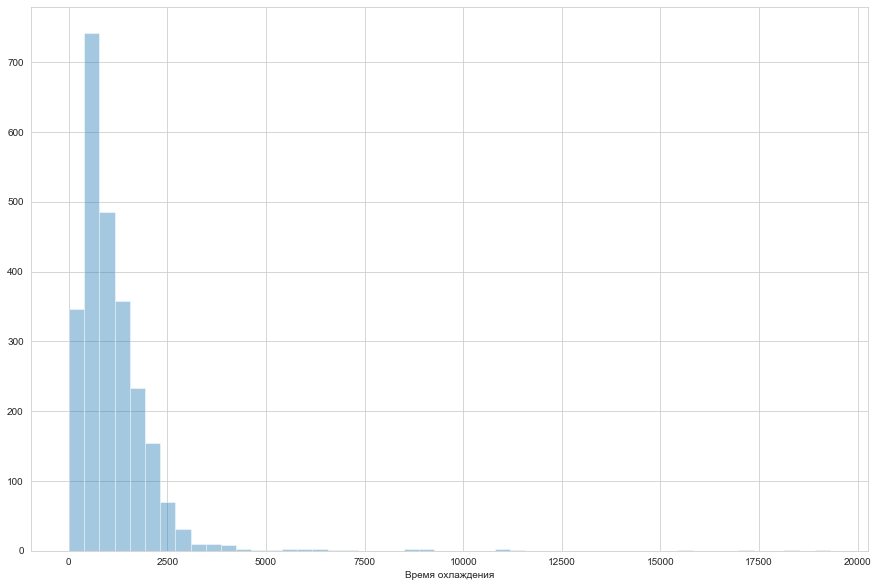

In [92]:
plt.figure(figsize=(15, 10))
sns.distplot(arc_temp['Время охлаждения'], label='Охлаждение', kde=False);

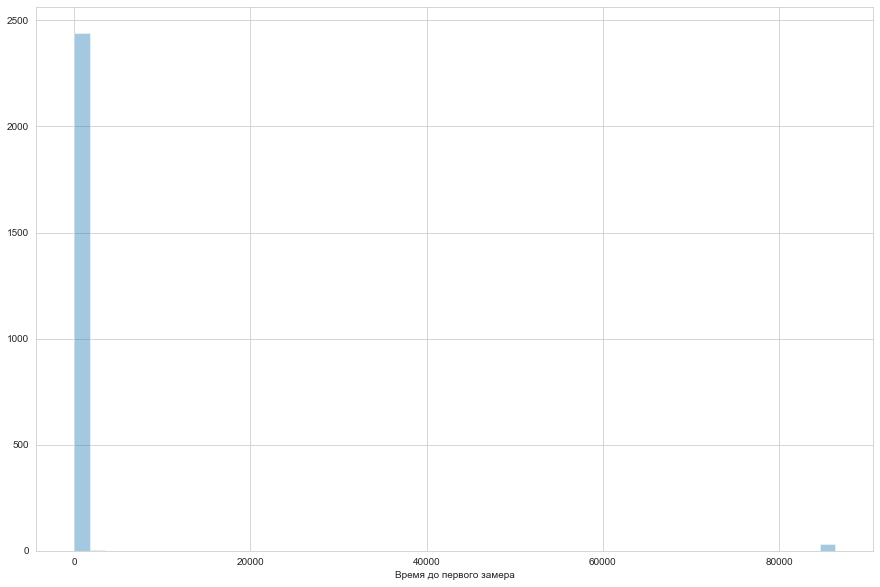

In [93]:
plt.figure(figsize=(15, 10))
sns.distplot(arc_temp['Время до первого замера'], label='Первый замер', kde=False);

In [94]:
arc_temp[arc_temp['Время до первого замера'] > 2000][['Время до первого замера', 'Начальный замер', 'Начало нагрева', 'key']].T

,109,201,503,508,529,556,929,935,1092,1322,1384,1447,1454,1467,1524,1574,1598,1599,1626,1750,1751,1761,1833,1878,1879,1938,1970,2212,2282,2290,2318,2327,2328,2441
Время до первого замера,85374,86297,86342,86129,86203,86342,85251,86195,86386,86330,86389,86257,86387,86354,85664,86220,86271,2433,86291,86293,86145,86364,86241,86299,86338,86244,86327,86317,86136,86278,86350,86280,86350,86253
Начальный замер,2019-05-07 06:56:56,2019-05-10 21:22:19,2019-05-22 10:46:49,2019-05-22 14:11:46,2019-05-23 06:54:19,2019-05-24 08:20:38,2019-06-07 07:57:01,2019-06-07 12:04:27,2019-06-12 17:42:18,2019-06-20 10:34:13,2019-06-22 20:33:52,2019-06-25 05:56:59,2019-06-25 13:41:21,2019-06-25 22:43:40,2019-06-28 00:47:46,2019-06-29 13:43:03,2019-06-30 07:22:43,2019-06-30 09:06:12,2019-07-01 03:21:09,2019-07-05 06:05:20,2019-07-05 06:29:37,2019-07-05 12:31:29,2019-07-08 02:06:39,2019-07-09 20:17:35,2019-07-09 20:54:54,2019-07-17 18:56:11,2019-07-19 06:34:23,2019-07-27 15:30:18,2019-07-30 03:18:08,2019-07-30 08:40:09,2019-07-31 06:19:14,2019-07-31 14:03:25,2019-07-31 14:57:12,2019-08-04 19:40:13
Начало нагрева,2019-05-07 07:14:02,2019-05-10 21:24:02,2019-05-22 10:47:47,2019-05-22 14:16:17,2019-05-23 06:57:36,2019-05-24 08:21:36,2019-06-07 08:16:10,2019-06-07 12:07:52,2019-06-12 17:42:32,2019-06-20 10:35:23,2019-06-22 20:34:03,2019-06-25 05:59:22,2019-06-25 13:41:34,2019-06-25 22:44:26,2019-06-28 01:00:02,2019-06-29 13:46:03,2019-06-30 07:24:52,2019-06-30 08:25:39,2019-07-01 03:22:58,2019-07-05 06:07:07,2019-07-05 06:33:52,2019-07-05 12:32:05,2019-07-08 02:09:18,2019-07-09 20:19:16,2019-07-09 20:55:56,2019-07-17 18:58:47,2019-07-19 06:35:36,2019-07-27 15:31:41,2019-07-30 03:22:32,2019-07-30 08:42:11,2019-07-31 06:20:04,2019-07-31 14:05:25,2019-07-31 14:58:02,2019-08-04 19:42:40
key,112,205,511,516,538,566,943,949,1106,1338,1400,1464,1471,1484,1541,1591,1615,1616,1643,1767,1768,1778,1850,1895,1896,1955,1987,2231,2302,2310,2338,2347,2348,2464


Судя по всему данные замеры температуры были сделаны до начала плавления - мы не можем их использовать.

In [95]:
arc_temp = arc_temp[arc_temp['Время до первого замера'] < 2500]

In [96]:
arc_temp.shape

(2442, 14)

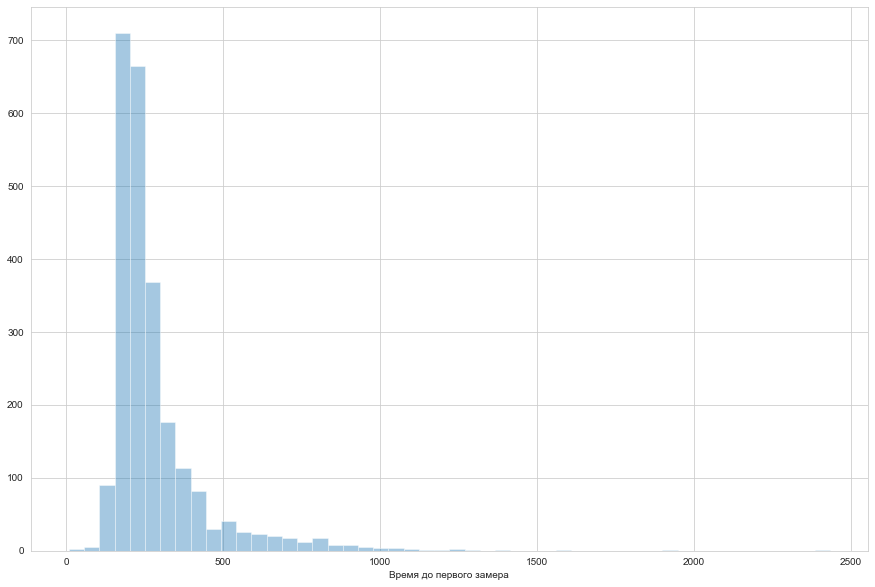

In [97]:
plt.figure(figsize=(15, 10))
sns.distplot(arc_temp['Время до первого замера'], label='Первый замер', kde=False);

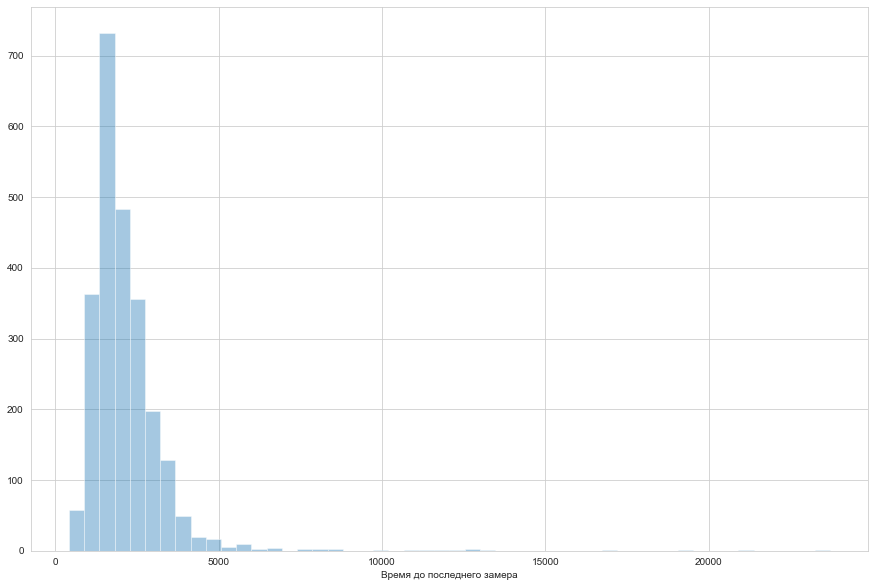

In [98]:
plt.figure(figsize=(15, 10))
sns.distplot(arc_temp['Время до последнего замера'], label='Последний замер', kde=False);

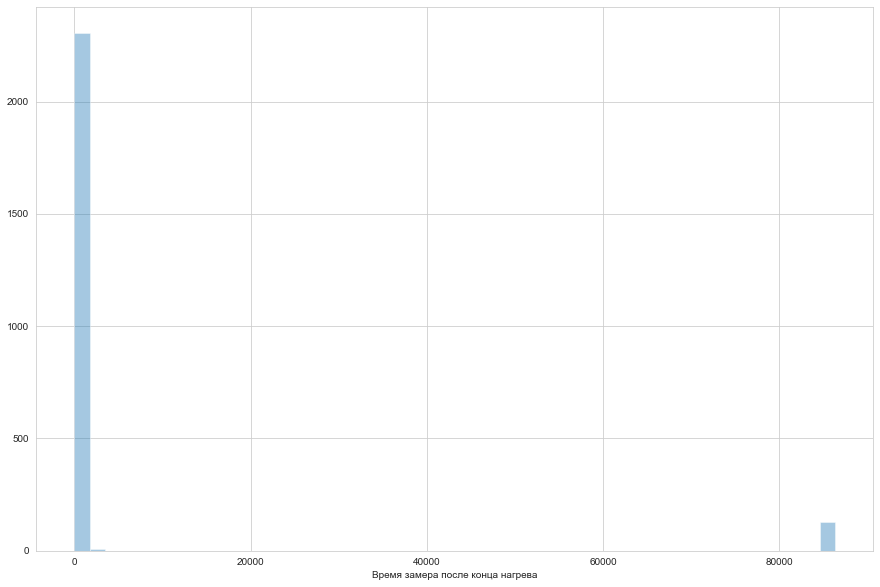

In [99]:
plt.figure(figsize=(15, 10))
sns.distplot(arc_temp['Время замера после конца нагрева'], label='Простой', kde=False);

In [100]:
arc_temp[arc_temp['Время замера после конца нагрева'] > 2500][['Время замера после конца нагрева', 'Конечный замер', 'Конец нагрева']].T

,10,37,40,48,61,66,70,78,174,176,177,179,182,209,212,216,218,263,267,288,291,292,316,320,321,437,438,441,446,449,463,464,465,484,526,552,576,577,578,580,582,583,586,605,627,630,692,718,720,728,...,1561,1601,1605,1606,1607,1622,1640,1666,1668,1695,1696,1703,1707,1794,1796,1820,1855,1856,1859,1929,1932,1947,1949,1972,1973,1975,1976,1977,2035,2060,2119,2121,2123,2124,2133,2192,2202,2242,2244,2246,2280,2283,2367,2368,2371,2376,2403,2405,2428,2434
Время замера после конца нагрева,86296,86353,86319,86331,86306,86301,86290,86310,86332,86275,86297,86301,86269,86254,86309,86250,86356,86308,86361,86301,86302,86300,86270,86292,86249,86339,86267,86302,86331,86272,86318,86286,86279,86238,86295,86237,86326,86102,86256,86332,86199,86323,86320,86299,86252,86170,86341,86359,86330,86320,...,86359,86295,86200,86043,86314,86217,86310,86306,86298,86166,86277,86171,86295,86317,86289,86346,86347,86146,86318,86207,86282,86328,86309,86286,86305,86273,86300,86257,86121,86300,86276,86296,86359,86277,86279,86288,86228,86315,86161,86352,86328,86295,86334,86272,86316,86056,86278,86266,86319,86343
Конечный замер,2019-05-03 17:27:23,2019-05-04 16:26:37,2019-05-04 20:48:10,2019-05-05 06:10:21,2019-05-05 17:26:46,2019-05-05 21:10:40,2019-05-05 23:41:58,2019-05-06 06:36:53,2019-05-09 23:52:30,2019-05-10 01:54:49,2019-05-10 03:11:16,2019-05-10 04:22:08,2019-05-10 06:04:26,2019-05-11 03:57:24,2019-05-11 06:28:59,2019-05-11 10:01:15,2019-05-11 12:41:44,2019-05-13 08:49:19,2019-05-13 14:57:47,2019-05-14 08:39:39,2019-05-14 10:45:15,2019-05-14 11:37:15,2019-05-15 08:07:49,2019-05-15 13:48:51,2019-05-15 14:14:51,2019-05-19 19:04:31,2019-05-19 20:05:01,2019-05-19 22:21:44,2019-05-20 03:34:14,2019-05-20 05:43:14,2019-05-20 19:33:54,2019-05-20 20:07:25,2019-05-20 20:44:08,2019-05-21 16:39:32,2019-05-23 04:07:00,2019-05-24 05:34:47,2019-05-25 01:28:18,2019-05-25 02:19:12,2019-05-25 03:16:42,2019-05-25 05:04:19,2019-05-25 07:01:17,2019-05-25 07:42:31,2019-05-25 10:00:00,2019-05-26 02:08:47,2019-05-26 23:02:37,2019-05-27 01:12:59,2019-05-29 10:07:32,2019-05-30 09:42:21,2019-05-30 10:58:04,2019-05-30 20:58:56,...,2019-06-29 05:01:21,2019-06-30 10:49:46,2019-06-30 13:34:28,2019-06-30 14:08:43,2019-06-30 14:57:31,2019-07-01 00:23:02,2019-07-01 15:29:42,2019-07-02 10:54:14,2019-07-02 12:41:09,2019-07-03 07:33:24,2019-07-03 07:58:10,2019-07-03 13:25:06,2019-07-03 16:20:43,2019-07-06 18:35:48,2019-07-06 20:08:00,2019-07-07 16:20:21,2019-07-08 21:00:45,2019-07-08 22:09:51,2019-07-09 00:45:43,2019-07-17 10:51:23,2019-07-17 12:20:08,2019-07-18 09:08:26,2019-07-18 11:34:48,2019-07-19 08:53:17,2019-07-19 09:33:35,2019-07-19 11:20:25,2019-07-19 12:38:09,2019-07-19 13:29:07,2019-07-21 15:50:27,2019-07-22 11:52:20,2019-07-24 16:11:35,2019-07-24 17:52:46,2019-07-24 20:25:35,2019-07-24 20:47:12,2019-07-25 04:48:20,2019-07-27 00:02:49,2019-07-27 07:09:43,2019-07-28 15:05:06,2019-07-28 16:14:39,2019-07-28 17:48:15,2019-07-30 02:27:12,2019-07-30 04:16:22,2019-08-02 07:44:39,2019-08-02 08:22:39,2019-08-02 10:12:01,2019-08-02 16:33:49,2019-08-03 11:12:36,2019-08-03 12:19:34,2019-08-04 10:04:13,2019-08-04 14:57:07
Конец нагрева,2019-05-03 17:29:07,2019-05-04 16:27:24,2019-05-04 20:49:31,2019-05-05 06:11:30,2019-05-05 17:28:20,2019-05-05 21:12:19,2019-05-05 23:43:48,2019-05-06 06:38:23,2019-05-09 23:53:38,2019-05-10 01:56:54,2019-05-10 03:12:59,2019-05-10 04:23:47,2019-05-10 06:06:37,2019-05-11 03:59:50,2019-05-11 06:30:30,2019-05-11 10:03:45,2019-05-11 12:42:28,2019-05-13 08:50:51,2019-05-13 14:58:26,2019-05-14 08:41:18,2019-05-14 10:46:53,2019-05-14 11:38:55,2019-05-15 08:09:59,2019-05-15 13:50:39,2019-05-15 14:17:22,2019-05-19 19:05:32,2019-05-19 20:07:14,2019-05-19 22:23:22,2019-05-20 03:35:23,2019-05-20 05:45:22,2019-05-20 19:35:16,2019-05-20 20:09:19,2019-05-20 20:46:09,2019-05-21 16:42:14,2019-05-23 04:08:45,2019-05-24 05:37:30,2019-05-25 01:29:32,2019-05-25 02:24:10,2019-05-25 03:19:06,2019-05-25 05:05:27,2019-05-25 07:04:38,2019-05-25 07:43:48,2019-05-25 10:01:20,2019-05-26 02:10:28,201

In [101]:
arc_temp[arc_temp['Время замера после конца нагрева'] > 2500].shape

(129, 14)

**Так как напрямую не указано, когда должны мериться температуры - будем считать, что начальная температура должна мериться после начала нагрева (мы отбросили не соответствующие данные выше) и после завершения процесса нагрева (т.е. отбросим данные замеров до завершения нагрева).** 

In [102]:
arc_temp = arc_temp[arc_temp['Время замера после конца нагрева'] < 2500]

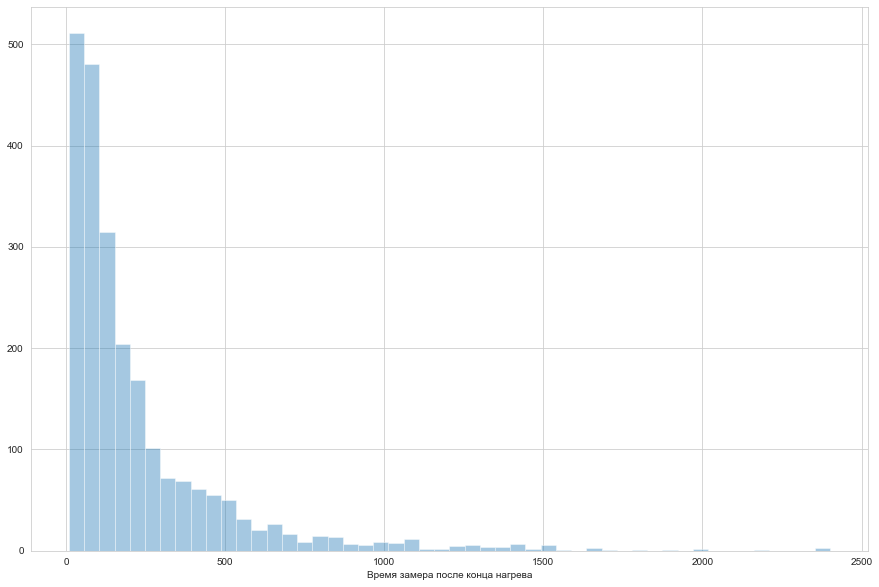

In [103]:
plt.figure(figsize=(15, 10))
sns.distplot(arc_temp['Время замера после конца нагрева'], label='Простой', kde=False);

Все наши графики со временем имеют правое смещение, возможно нужно посчитать такие данные выбросами и удалить, но пока оставим.

In [104]:
arc_temp.shape

(2313, 14)

In [105]:
arc_temp.head()

,key,Начальный замер,Начальная температура,Конечный замер,Конечная температура,Начало нагрева,Конец нагрева,Суммарное время нагрева,Суммарная полная мощ нагрева,Количество нагревов,Время охлаждения,Время до первого замера,Время до последнего замера,Время замера после конца нагрева
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,2019-05-03 11:02:14,2019-05-03 11:28:37,1098,5.826395,5,485,844,1705,122
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,2019-05-03 11:34:14,2019-05-03 11:53:18,811,3.649216,4,333,193,1498,354
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,2019-05-03 12:06:54,2019-05-03 12:32:19,655,2.989534,5,870,383,1683,158
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,2019-05-03 12:39:37,2019-05-03 12:57:50,741,3.814962,4,352,800,1188,95
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,2019-05-03 13:11:13,2019-05-03 13:33:55,869,4.035758,4,493,726,1488,126


In [106]:
# удалим признак времени после конца нагрева - он больше не нужен
arc_temp.drop(['Время замера после конца нагрева'], axis=1, inplace=True)

**Теперь займемся соединением данных о материалах и газах**

Сначала попробуем добавить только объемы и посмотрим улучшиться ли качество моделей

In [107]:
arc_temp_bulk = arc_temp.merge(bulk_vol, on='key')

In [108]:
arc_temp_bulk.head()

,key,Начальный замер,Начальная температура,Конечный замер,Конечная температура,Начало нагрева,Конец нагрева,Суммарное время нагрева,Суммарная полная мощ нагрева,Количество нагревов,Время охлаждения,Время до первого замера,Время до последнего замера,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,2019-05-03 11:02:14,2019-05-03 11:28:37,1098,5.826395,5,485,844,1705,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,2019-05-03 11:34:14,2019-05-03 11:53:18,811,3.649216,4,333,193,1498,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,2019-05-03 12:06:54,2019-05-03 12:32:19,655,2.989534,5,870,383,1683,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,2019-05-03 12:39:37,2019-05-03 12:57:50,741,3.814962,4,352,800,1188,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,2019-05-03 13:11:13,2019-05-03 13:33:55,869,4.035758,4,493,726,1488,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [109]:
arc_temp_bulk_wire = arc_temp_bulk.merge(wire, on='key')

In [110]:
arc_temp_bulk_wire.head()

,key,Начальный замер,Начальная температура,Конечный замер,Конечная температура,Начало нагрева,Конец нагрева,Суммарное время нагрева,Суммарная полная мощ нагрева,Количество нагревов,Время охлаждения,Время до первого замера,Время до последнего замера,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,2019-05-03 11:02:14,2019-05-03 11:28:37,1098,5.826395,5,485,844,1705,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,2019-05-03 11:34:14,2019-05-03 11:53:18,811,3.649216,4,333,193,1498,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,2019-05-03 12:06:54,2019-05-03 12:32:19,655,2.989534,5,870,383,1683,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,2019-05-03 12:39:37,2019-05-03 12:57:50,741,3.814962,4,352,800,1188,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,2019-05-03 13:11:13,2019-05-03 13:33:55,869,4.035758,4,493,726,1488,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
arc_temp_bulk_wire.fillna(0, inplace=True)

Еще раз посмотрим на данные по газу и смержим с общей таблицей по электродам и температурам

In [112]:
gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [113]:
gas.shape

(3239, 2)

In [114]:
full_data = arc_temp_bulk_wire.merge(gas, on='key')

In [115]:
full_data.head()

,key,Начальный замер,Начальная температура,Конечный замер,Конечная температура,Начало нагрева,Конец нагрева,Суммарное время нагрева,Суммарная полная мощ нагрева,Количество нагревов,Время охлаждения,Время до первого замера,Время до последнего замера,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,2019-05-03 11:02:14,2019-05-03 11:28:37,1098,5.826395,5,485,844,1705,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,2019-05-03 11:34:14,2019-05-03 11:53:18,811,3.649216,4,333,193,1498,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,2019-05-03 12:06:54,2019-05-03 12:32:19,655,2.989534,5,870,383,1683,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,2019-05-03 12:39:37,2019-05-03 12:57:50,741,3.814962,4,352,800,1188,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,2019-05-03 13:11:13,2019-05-03 13:33:55,869,4.035758,4,493,726,1488,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692


In [116]:
full_data.shape

(2182, 38)

In [117]:
# удалим признаки времени
full_data.drop(['Начальный замер', 'Конечный замер', 'Начало нагрева', 'Конец нагрева'], axis=1, inplace=True)

In [118]:
full_data.shape

(2182, 34)

In [119]:
full_data.head()

,key,Начальная температура,Конечная температура,Суммарное время нагрева,Суммарная полная мощ нагрева,Количество нагревов,Время охлаждения,Время до первого замера,Время до последнего замера,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1
0,1,1571.0,1613.0,1098,5.826395,5,485,844,1705,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,1581.0,1602.0,811,3.649216,4,333,193,1498,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,1596.0,1599.0,655,2.989534,5,870,383,1683,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,4,1601.0,1625.0,741,3.814962,4,352,800,1188,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,5,1576.0,1602.0,869,4.035758,4,493,726,1488,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692


## 3. Simple model checking and features selection

Прежде посмотрим на корреляцию признаков

In [120]:
correlations_data = full_data.corr()['Конечная температура'].sort_values()

In [121]:
correlations_data

Wire 2                         -0.222871
Bulk 6                         -0.202288
Wire 4                         -0.164537
Wire 7                         -0.141091
Bulk 7                         -0.110779
Bulk 11                        -0.106998
key                            -0.095473
Wire 6                         -0.087548
Bulk 2                         -0.085446
Bulk 1                         -0.073061
Wire 3                         -0.050157
Bulk 3                         -0.041898
Wire 9                         -0.032312
Bulk 5                         -0.030510
Bulk 8                         -0.027506
Bulk 9                         -0.017349
Wire 8                         -0.011896
Bulk 13                        -0.006563
Время до первого замера         0.026739
Время охлаждения                0.042156
Газ 1                           0.060941
Bulk 10                         0.067116
Время до последнего замера      0.100138
Bulk 14                         0.120274
Количество нагре

**Похоже добавка материалов играет важную роль в формировании конечной температуры**

In [122]:
# разобьем данные, оставим только данные с конечными температурами
X = full_data[full_data['Конечная температура'] != 0].drop(['Конечная температура'], axis=1)
y = full_data[full_data['Конечная температура'] != 0]['Конечная температура']

In [123]:
X.shape, y.shape

((2182, 33), (2182,))

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [125]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1745, 33), (437, 33), (1745,), (437,))

In [126]:
# теперь сама модель - случайный лес - простая модель и есть отображение важности признаков
rf = RandomForestRegressor(n_estimators=250, criterion='mae', max_depth=6, bootstrap=True, random_state=42, verbose=1, \
                           n_jobs=-1)

In [127]:
%%time
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    3.8s


Wall time: 5.34 s


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    5.1s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=250, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=1, warm_start=False)

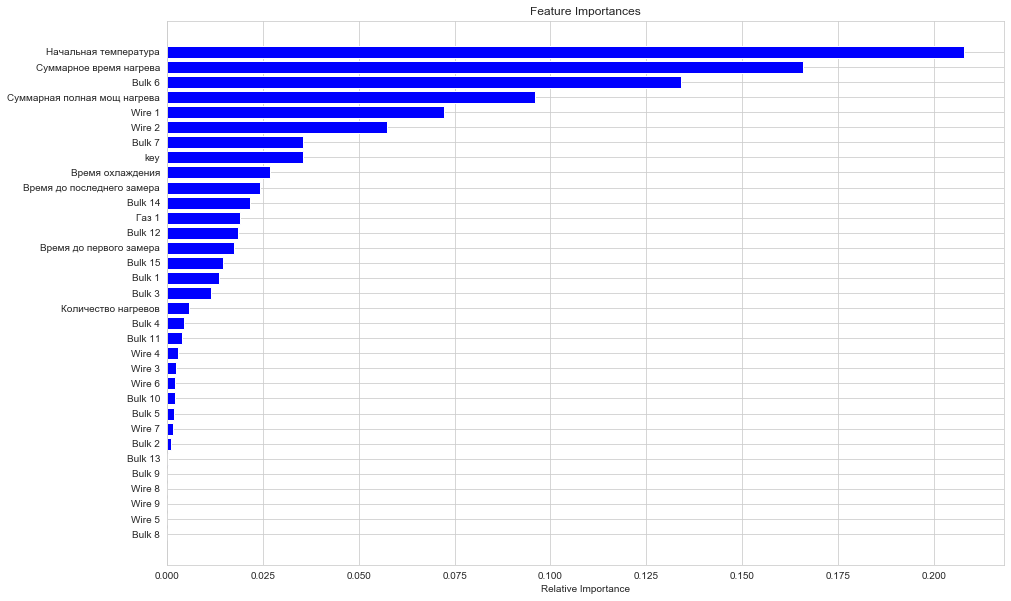

In [128]:
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(15, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**Самый важный признак - начальная температура, для предсказания - да, для снижения энергопотребления - нет. Далее суммарное время нагрева и суммарная полная мощность - эти логичны.**

**В ПРИНЦИПЕ УДАЛЯЕМ ИЗ МОДЕЛИ ПРИЗНАКИ НЕ ИМЕЮЩИЕ НИКАКОГО ВЛИЯНИЯ - 6 ПОСЛЕДНИХ**

Проверим на валидационной выборке

In [129]:
predict = rf.predict(X_test)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 250 out of 250 | elapsed:    0.0s finished


In [130]:
mean_absolute_error(predict, y_test)

6.271240274599538

In [131]:
mae_rf_full = mean_absolute_error(predict, y_test)

Выглядит очень даже не плохо. Почистим признаки и попробуем еще раз эту же модель.

In [132]:
new_X_train = X_train.drop(['Bulk 13', 'Bulk 9', 'Wire 8', 'Wire 9', 'Wire 5', 'Bulk 8', 'key'], axis=1)
new_X_test = X_test.drop(['Bulk 13', 'Bulk 9', 'Wire 8', 'Wire 9', 'Wire 5', 'Bulk 8', 'key'], axis=1)

In [133]:
rf_new = RandomForestRegressor(n_estimators=250, criterion='mae', max_depth=6, bootstrap=True, random_state=42, verbose=1, \
                           n_jobs=-1)

In [134]:
%%time
rf_new.fit(new_X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    3.5s


Wall time: 4.83 s


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    4.7s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=250, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=1, warm_start=False)

In [135]:
new_predict = rf_new.predict(new_X_test)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 250 out of 250 | elapsed:    0.0s finished


In [136]:
mean_absolute_error(new_predict, y_test)

6.254800915331812

In [137]:
mae_rf_part = mean_absolute_error(new_predict, y_test)

**Стало немного лучше)))**

Теперь попробуем lightgbm на отобранных. Придется переименовать признаки на английский

In [138]:
X_train.columns

Index(['key', 'Начальная температура', 'Суммарное время нагрева',
       'Суммарная полная мощ нагрева', 'Количество нагревов',
       'Время охлаждения', 'Время до первого замера',
       'Время до последнего замера', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4',
       'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11',
       'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2',
       'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9',
       'Газ 1'],
      dtype='object')

In [139]:
columns = ['key', 'Start temp', 'Sum heating time', 'Sum heating total power',
       'heating count', 'Cool time', 'Time to first measure',
       'Time to last measure', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4',
       'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11',
       'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2',
       'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'Gas']

In [140]:
X_train.columns = columns
X_test.columns = columns

In [141]:
new_X_train = X_train.drop(['Bulk 13', 'Bulk 9', 'Wire 8', 'Wire 9', 'Wire 5', 'Bulk 8', 'key'], axis=1)
new_X_test = X_test.drop(['Bulk 13', 'Bulk 9', 'Wire 8', 'Wire 9', 'Wire 5', 'Bulk 8', 'key'], axis=1)

In [142]:
lgbm = lightgbm.LGBMRegressor(colsample_bytree=0.6, random_state=42, n_jobs=-1)

In [143]:
%%time
lgbm.fit(X_train, y_train)

Wall time: 92 ms


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [144]:
lgbm_predict = lgbm.predict(X_test)

In [145]:
mean_absolute_error(lgbm_predict, y_test)

5.703927241169494

LightGBM явно много лучше, но попробуем улучшить и его предсказания

In [146]:
lgbm_params = {
    'n_estimators' : [250, 500, 1000],
    'learning_rate' : [0.1, 0,2, 0.3],
    'colsample_bytree' : [0.4, 0.6, 0.8],
    'max_depth' : range(4, 11)
}

In [147]:
lgbm_grid = GridSearchCV(lgbm, param_grid=lgbm_params, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1, verbose=1)

In [148]:
%%time
lgbm_grid.fit(X_train, y_train)

Fitting 3 folds for each of 252 candidates, totalling 756 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   18.0s


Wall time: 49.8 s


[Parallel(n_jobs=-1)]: Done 756 out of 756 | elapsed:   49.6s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=0.6,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=42,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.4, 0.6, 0.8],
                         'learning_rate': [0.1, 0, 2, 0.3],
                         'max_depth': range(4, 11),
          

In [149]:
lgbm_grid.best_score_

-5.681668945100465

In [150]:
lgbm_grid.best_estimator_, lgbm_grid.best_params_

(LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               importance_type='split', learning_rate=0.1, max_depth=4,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=250, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 {'colsample_bytree': 0.8,
  'learning_rate': 0.1,
  'max_depth': 4,
  'n_estimators': 250})

In [151]:
lgbm_grid_predict = lgbm_grid.predict(X_test)

In [152]:
mean_absolute_error(lgbm_grid_predict, y_test)

5.58295984728422

In [153]:
mae_lgbm_full = mean_absolute_error(lgbm_grid_predict, y_test)

In [154]:
new_lgbm_grid = GridSearchCV(lgbm, param_grid=lgbm_params, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1, verbose=1)

In [155]:
%%time
new_lgbm_grid.fit(new_X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 3 folds for each of 252 candidates, totalling 756 fits


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 424 tasks      | elapsed:   20.2s


Wall time: 44.4 s


[Parallel(n_jobs=-1)]: Done 756 out of 756 | elapsed:   44.2s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=0.6,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=42,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.4, 0.6, 0.8],
                         'learning_rate': [0.1, 0, 2, 0.3],
                         'max_depth': range(4, 11),
          

In [156]:
new_lgbm_grid.best_score_

-5.758370340291798

In [157]:
new_lgbm_grid.best_estimator_, new_lgbm_grid.best_params_

(LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               importance_type='split', learning_rate=0.1, max_depth=4,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=250, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 {'colsample_bytree': 0.8,
  'learning_rate': 0.1,
  'max_depth': 4,
  'n_estimators': 250})

In [158]:
new_lgbm_grid_predict = new_lgbm_grid.predict(new_X_test)

In [159]:
mean_absolute_error(new_lgbm_grid_predict, y_test)

5.625887822604532

In [160]:
mae_lgbm_part = mean_absolute_error(new_lgbm_grid_predict, y_test)

Очень занятно - для случайного леса лучше брать меньше признакво, а lightgbm - больше признаков, они дают лучшее значение метрики.

**Попробуем простую нейронную сеть**

In [161]:
# для нейронной сети шкалируем значения признаков
from sklearn.preprocessing import StandardScaler

In [162]:
scaler = StandardScaler()

In [163]:
net_X_train = scaler.fit_transform(X_train)

In [164]:
net_X_train.shape

(1745, 33)

In [165]:
net_X_test = scaler.transform(X_test)

In [166]:
net_X_train[:3]

array([[-1.32803454, -0.50104237,  0.92757648,  0.91256541,  0.84337391,
        -0.01278896,  0.45435888,  0.08621105, -0.27156117, -0.07921027,
        -0.36325119, -0.62131869, -0.11230737,  1.1134301 , -0.06767488,
         0.        , -0.06226177, -0.23994349, -0.19087122, -0.6716756 ,
        -0.07165462,  0.65517763, -1.43265663, -0.47815756, -0.52342858,
        -0.12207706, -0.06730428,  0.        , -0.11378729, -0.03337875,
        -0.06030548, -0.09334604,  1.09309192],
       [ 1.7322678 ,  0.88612103, -1.51142804, -1.46192567, -1.68856152,
        -0.96784501,  0.06535052,  0.07030868, -0.27156117, -0.07921027,
        -0.63991945, -0.62131869, -0.11230737,  1.36175578, -0.06767488,
         0.        , -0.06226177, -0.23994349,  0.89982146, -0.6716756 ,
        -0.07165462, -0.08541982, -0.19308092, -0.82432635, -0.52856973,
        -0.12207706, -0.06730428,  0.        , -0.11378729, -0.03337875,
        -0.06030548, -0.09334604, -0.09294915],
       [ 0.7234078 , -0.3657

In [167]:
net_X_test[:3]

array([[-1.28166632, -0.7717084 ,  0.45806811,  0.55257227,  0.21039005,
        -0.08958282,  0.55161097, -0.07187721, -0.27156117, -0.07921027,
        -0.63991945,  2.04055702, -0.11230737, -0.41199902, -0.06767488,
         0.        , -0.06226177, -0.23994349, -0.19087122, -0.03356915,
        -0.07165462, -0.30759905,  0.98689979, -0.12129805, -0.52856973,
        -0.12207706, -0.06730428,  0.        , -0.11378729, -0.03337875,
        -0.06030548, -0.09334604, -0.42455792],
       [-0.97113978,  0.07412294,  0.21416766,  0.38563688,  0.21039005,
         0.56478741, -0.40946851,  0.79807596, -0.27156117, -0.07921027,
         1.87644423, -0.62131869, -0.11230737, -0.41199902, -0.06767488,
         0.        , -0.06226177, -0.23994349, -0.19087122,  0.40034323,
        -0.07165462, -0.66555448,  0.98689979,  0.71321648, -0.52856973,
        -0.12207706, -0.06730428,  0.        , -0.11378729, -0.03337875,
        -0.06030548, -0.09334604,  1.20135443],
       [ 0.33981619, -0.8732

In [168]:
full_model = keras.models.Sequential()

full_model.add(keras.layers.Dense(units=net_X_train.shape[1] * 2, input_dim=net_X_train.shape[1], activation='sigmoid'))
full_model.add(keras.layers.Dense(units=net_X_train.shape[1], activation='sigmoid'))
full_model.add(keras.layers.Dense(units=net_X_train.shape[1] / 2))
full_model.add(keras.layers.Dense(units=1))

full_model.compile(loss='mean_absolute_error', optimizer='Adam')

In [169]:
full_model.fit(net_X_train, y_train, epochs=100, verbose=1, validation_split=0.1)

Train on 1570 samples, validate on 175 samples
Epoch 1/100
1570/1570 [==============================] - 0s 251us/sample - loss: 1589.0647 - val_loss: 1584.2051
Epoch 2/100
1570/1570 [==============================] - 0s 34us/sample - loss: 1577.2401 - val_loss: 1569.0636
Epoch 3/100
1570/1570 [==============================] - 0s 34us/sample - loss: 1558.3003 - val_loss: 1545.4518
Epoch 4/100
1570/1570 [==============================] - 0s 34us/sample - loss: 1529.3234 - val_loss: 1510.9233
Epoch 5/100
1570/1570 [==============================] - 0s 34us/sample - loss: 1491.4894 - val_loss: 1470.1939
Epoch 6/100
1570/1570 [==============================] - 0s 34us/sample - loss: 1447.9727 - val_loss: 1423.5362
Epoch 7/100
1570/1570 [==============================] - 0s 33us/sample - loss: 1398.3055 - val_loss: 1370.5874
Epoch 8/100
1570/1570 [==============================] - 0s 34us/sample - loss: 1342.2979 - val_loss: 1311.2681
Epoch 9/100
1570/1570 [==============================] -

In [170]:
first_result = full_model.predict(net_X_test)

In [171]:
mean_absolute_error(first_result, y_test)

5.554807056278604

In [172]:
mae_net_full = mean_absolute_error(first_result, y_test)

In [173]:
net_new_X_train = scaler.fit_transform(new_X_train)

In [174]:
net_new_X_test = scaler.transform(new_X_test)

In [175]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(units=net_new_X_train.shape[1] * 2, input_dim=net_new_X_train.shape[1], activation='sigmoid'))
model.add(keras.layers.Dense(units=net_new_X_train.shape[1], activation='sigmoid'))
model.add(keras.layers.Dense(units=net_new_X_train.shape[1] / 2))
model.add(keras.layers.Dense(units=1))

model.compile(loss='mean_absolute_error', optimizer='Adam')

In [176]:
model.fit(net_new_X_train, y_train, epochs=100, verbose=1, validation_split=0.1)

Train on 1570 samples, validate on 175 samples
Epoch 1/100
1570/1570 [==============================] - 0s 286us/sample - loss: 1591.1489 - val_loss: 1588.2954
Epoch 2/100
1570/1570 [==============================] - 0s 32us/sample - loss: 1583.4557 - val_loss: 1577.8238
Epoch 3/100
1570/1570 [==============================] - 0s 33us/sample - loss: 1570.0995 - val_loss: 1561.4681
Epoch 4/100
1570/1570 [==============================] - 0s 32us/sample - loss: 1551.0422 - val_loss: 1539.3833
Epoch 5/100
1570/1570 [==============================] - 0s 34us/sample - loss: 1526.6699 - val_loss: 1512.9534
Epoch 6/100
1570/1570 [==============================] - 0s 33us/sample - loss: 1498.4287 - val_loss: 1482.6841
Epoch 7/100
1570/1570 [==============================] - 0s 34us/sample - loss: 1466.2139 - val_loss: 1448.3502
Epoch 8/100
1570/1570 [==============================] - 0s 33us/sample - loss: 1429.9057 - val_loss: 1409.9045
Epoch 9/100
1570/1570 [==============================] -

Epoch 76/100
1570/1570 [==============================] - 0s 32us/sample - loss: 5.1306 - val_loss: 5.7277
Epoch 77/100
1570/1570 [==============================] - 0s 32us/sample - loss: 5.1358 - val_loss: 5.7482
Epoch 78/100
1570/1570 [==============================] - 0s 33us/sample - loss: 5.1000 - val_loss: 5.7296
Epoch 79/100
1570/1570 [==============================] - 0s 33us/sample - loss: 5.0961 - val_loss: 5.8091
Epoch 80/100
1570/1570 [==============================] - 0s 32us/sample - loss: 5.1378 - val_loss: 5.6822
Epoch 81/100
1570/1570 [==============================] - 0s 33us/sample - loss: 5.1198 - val_loss: 5.7435
Epoch 82/100
1570/1570 [==============================] - 0s 32us/sample - loss: 5.0689 - val_loss: 5.8301
Epoch 83/100
1570/1570 [==============================] - 0s 32us/sample - loss: 5.2111 - val_loss: 5.6655
Epoch 84/100
1570/1570 [==============================] - 0s 32us/sample - loss: 5.0405 - val_loss: 5.6358
Epoch 85/100
1570/1570 [=============

In [177]:
second_result = model.predict(net_new_X_test)

In [178]:
second_result[:10]

array([[1595.4354],
       [1598.2761],
       [1595.8768],
       [1586.3751],
       [1610.0702],
       [1603.8597],
       [1593.0647],
       [1578.0361],
       [1598.3406],
       [1580.9093]], dtype=float32)

In [179]:
mean_absolute_error(second_result, y_test)

5.907744732819651

In [180]:
mae_net_part = mean_absolute_error(second_result, y_test)

**А сеть дает результаты лучше на полном наборе признаков. Хотя значения примерно одинаковы**

### Для пердсказания выбираем - lightGBM на полном наборе признаков и Нейросеть на полном наборе признаков. Затем сделаем блендинг для создания более устойчивой предсказательной модели. 

In [181]:
# first_result - предсказания сети full
# lgbm_grid_predict - предсказания lightgbm full

test_result_1_full = [x[0] * 0.5 for x in first_result]

In [182]:
test_result_2_full = [x * 0.5 for x in lgbm_grid_predict]

In [183]:
test_result_full = np.array(test_result_1_full) + np.array(test_result_2_full)

In [184]:
len(test_result_full)

437

In [185]:
mean_absolute_error(test_result_full, y_test)

5.291758531055101

In [186]:
mean_absolute_error(first_result, y_test)

5.554807056278604

In [187]:
mean_absolute_error(lgbm_grid_predict, y_test)

5.58295984728422

In [188]:
mae_blend_full = mean_absolute_error(test_result_full, y_test)

In [189]:
# second_result - предсказания сети part
# new_lgbm_grid_predict - предсказания lightgbm part

test_result_1_part = [x[0] * 0.5 for x in second_result]

In [190]:
test_result_2_part = [x * 0.5 for x in new_lgbm_grid_predict]

In [191]:
test_result_part = np.array(test_result_1_part) + np.array(test_result_2_part)

In [192]:
mean_absolute_error(test_result_part, y_test)

5.530927955478

In [193]:
mae_blend_part = mean_absolute_error(test_result_part, y_test)

**Лучше чем lightgbm и даже сеть**

In [194]:
# построим датафрейм с признаками качества моделей
results = pd.DataFrame({'mae random forest' : [mae_rf_full, mae_rf_part],
                       'mae lgbm' : [mae_lgbm_full, mae_lgbm_part],
                       'mae net' : [mae_net_full, mae_net_part],
                       'mae blend' : [mae_blend_full, mae_blend_part]},
                      index=['full feature', 'part features'])

In [195]:
results

,mae random forest,mae lgbm,mae net,mae blend
full feature,6.271240,5.582960,5.554807,5.291759
part features,6.254801,5.625888,5.907745,5.530928


## ВЫВОД: 
ЛУЧШАЯ МОДЕЛЬ (ОДИНОЧНАЯ) - НЕЙРОННАЯ СЕТЬ НА ПОЛНОМ НАБОРЕ ПРИЗНАКОВ. НО, ОЧЕВИДНО, БЛЕНДИНГ ПОБЕЖДАЕТ ПО КАЧЕСТВУ ПРЕДСКАЗАНИЙ, ПРИНИМАЕМ МОДЕЛЬ БЛЕНДИНГА НА ПОЛНОМ НАБОРЕ ДАННЫХ КАК ОСНОВНУЮ ПРЕДСКАЗАТЕЛЬНУЮ МОДЕЛЬ. ЗНАЧЕНИЕ МАЕ ПРИ ПРОВЕРКЕ МЕНЯЮТСЯ И ВЫВОДЫ НЕМНОГО МОГУТ ОТЛИЧАТЬСЯ, НО ОНИ НАПИСАНЫ ПО ПОСЛЕДНИМ ДАННЫМ.

## Мой план и что удалось выполнить

## Дальнейший план:

- [x] Соединил бы датасеты о материалах в один - добавил к общему датасету с температурами и данными об электродах.
- [x] Соединил бы данные об электродах и температурах - сделано через pivot_table.
- [x] Подумать как соединить все получившиеся датасеты в один и соединить с данными о газе - соединил все датасеты в один по признаку key (кроме времени материалов - сыпучих и проволочных).
- [x] Или до первых трех пунктов или после, заполнить пропуски - стратегия заполнения зависит от данных. Самая хитрая думаю должна быть для температуры замеров. - Пропуски заполнил только у материалов (у температуры только для того чтобы легче отбросить было). **Долго думал, что нужн опредсказать пропущенные конечные температуры у экземпляров которых есть начальная температура...отныло много времени и сил.**
- [x] Подумать над созданием новых признаков - Нагенерил множество прижнаков, потом оставил только самые, на мой взгляд. логичные и не коллинеарные.
- [x] Определить главный критерий потребления электроэнергии - пока видиться время нагрева общее. Судя по модели - главный признак начальная температура нагрева, далее время нагрева и полная суммарная мощность нагрева. Последние признаки логичны и ими как раз можно контролировать электропотребление, но нужна большая проработка вопроса для понимания куда копать дальше и как наша модель поможет в снижении потребления.
- [x] Подумать как можно оптимизировать (снизить) время нагрева и как в этом может помочь машинное обучение. Как сказал выше - нужно капать дальше. Пока взял направление общения с технолагами как снизить время нагрева и мощность при сохранении температур процесса (если возможно), потом влияние материалов, т.к. их тип и объем также определяют время и мощность нагрева... А дальше все по кругу - улучшаем модель, общаемся с заказчиком, улучшаем модель.

## Трудности:

- Как писал выше, главная трудность это осознание того, что не нужно предсказывать значение конечной температуры у значений с начальной температурой и пропущенной конечной.
- Понимание какие из сгенерированных признаков брать. Генерил и отношение мощностей и различные варианты новых и старых признаков - средние, минимальные, максимальные. В итоге отобрал по логике и с помощью ревьюера - хороший попался)))
- Также были некоторые трудности с созданием pivot_table, но как-то в этом раз быстро они решились)
- Немного помучался с нейросетью, как-то плохо у меня идет их конструирование и оптимизация параметров.

## Ключевые шаги:

- Как всегда самым сложным и значимым оказалось исследование данных и их визуализация. Для меня это самое сложное и любимое задание, хоть и не считаю это трудностями, поэтому и не отнес в предыдущих раздел.
- Формирование новых признаков и осознание какие конкретно значими и необходимы.
- Соединение пивотов и соединение всех данных в один датасет (в процессе написания возникла идея проверить как соотноситься время добавки материалов и время процесса - может также есть выпадающие по времени добавки, что можно было бы отбросить и улучшить модель, ну или какую-то другую взаимосвязь - займусь этим в свободно время после сдачи проекта)))
- Выбор модели подходящей для решения задачи регрессии с большим количеством признаков, простой в реализации и понятной (для меня).
- Оценка результатов и выводы по работе и по улучшению качества моделей.

## Итоговая модель:

- Лучшей моделью выбрана блендинг модель на полном наборе данных.
- Лучшая одиночная модель - нейронная сеть на полном наборе признаков (данных).